# Spatial Validation CESM LME

In [2]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [4]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils_kb as limkb
import LIM_building as limbuild
import LIM_stats_kb as statskb

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [5]:
plt.rcParams['figure.dpi']=300

In [6]:
def get_title_strings(var,exp_setup,forecast):
    if 'cmip6' in exp_setup['train_dsource']: 
        tcmip='CMIP6'
    elif 'era' in exp_setup['train_dsource']:
        tcmip=''
    elif 'satellite' in exp_setup['train_dsource']: 
        tcmip=''
    elif 'lme' in exp_setup['train_dsource']: 
        tcmip=''
    else: 
        tcmip='CMIP5'

    if 'cmip6' in exp_setup['valid_dsource']: 
        vcmip='CMIP6'
    elif 'era' in exp_setup['valid_dsource']:
        vcmip=''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vcmip=''
    elif 'lme' in exp_setup['valid_dsource']: 
        vcmip=''
    else: 
        vcmip='CMIP5'

    # start_tim = exp_setup['nyears_startvalid']
    # end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
    valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                     str(forecast['var_dict_valid'][var]['time'][-1])[:4])

    if 'hist' in exp_setup['train_dsource']:
        texp = 'Historical'
    elif 'lm' in exp_setup['train_dsource']: 
        texp = 'LM'
    elif 'ssp585' in exp_setup['train_dsource']: 
        texp = 'SSP585'
    elif 'era5' in exp_setup['train_dsource']: 
        texp = 'ERA5'
    elif 'satellite' in exp_setup['train_dsource']: 
        texp = 'Satellite'
    elif 'lme' in exp_setup['train_dsource']: 
        texp = 'LME'

    if 'hist' in exp_setup['valid_dsource']:
        vexp = 'Historical'
    elif 'lm' in exp_setup['valid_dsource']: 
        vexp = 'LM'
    elif 'ssp585' in exp_setup['valid_dsource']: 
        vexp = 'SSP585'
    elif 'era5' in exp_setup['valid_dsource']: 
        vexp = 'ERA5'
    elif 'satellite' in exp_setup['valid_dsource']: 
        vexp = 'Satellite'
    elif 'lme' in exp_setup['valid_dsource']: 
        vexp = 'LME'

    if 'cesm2' in exp_setup['train_dsource']:
        tmod = 'CESM2'
    elif 'mpi' in exp_setup['train_dsource']: 
        tmod = 'MPI'
    elif 'gfdl' in exp_setup['train_dsource']: 
        tmod = 'GFDL'
    elif 'ccsm4' in exp_setup['train_dsource']: 
        tmod = 'CCSM4'
    elif 'era5' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'satellite' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'lme' in exp_setup['train_dsource']: 
        tmod = 'CESM'

    if 'cesm2' in exp_setup['valid_dsource']:
        vmod = 'CESM2'
    elif 'mpi' in exp_setup['valid_dsource']: 
        vmod = 'MPI'
    elif 'gfdl' in exp_setup['valid_dsource']: 
        vmod = 'GFDL'
    elif 'ccsm4' in exp_setup['valid_dsource']: 
        vmod = 'CCSM4'
    elif 'era5' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'lme' in exp_setup['valid_dsource']: 
        vmod = 'CESM'

    if exp_setup['Weight'] is True: 
        wt_addin = ' '
    else: 
        wt_addin = '(no area weighting)'

    if exp_setup['detrend'] is True: 
        tr_addin = ' '
    else: 
        tr_addin = ' (trended)'
        
    return tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, wt_addin, tr_addin

In [7]:
def load_validation_data(var, exp_setup, remove_climo=True, detrend=True, verbose=True):
    ## LOad Truth data: 
    fdic_valid = limkb.build_training_dic(exp_setup['valid_dsource'])
    v = {}
    tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])
    #        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
    if tecut <=0: 
        tecut = False
    print('tecut = '+str(tecut) +', tscut = '+str(exp_setup['nyears_startvalid']/12))

    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=remove_climo, detrend=detrend, 
                               verbose=verbose,tscut=int(exp_setup['nyears_startvalid']/12), 
                               tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'])

    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var = X_var/100
    
    return X_var

In [8]:
def calc_validation_stats_spatial(lag_int,var,X_var,exp_setup,forecast,LIMd):
    ## Calculate validation statistics: 
    [truth_anom, 
     forecast_anom] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup['mo'],X_var,
                                                            forecast['x_forecast_dcomp'],
                                                            LIMd_is['var_dict'],insamp=exp_setup['Insamp'])


    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))

    corr=np.zeros(truth_anom.shape[0])
    ce=np.zeros(truth_anom.shape[0])

    for i in range(truth_anom.shape[0]):
        corr[i] = np.corrcoef(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))[0,1]
        ce[i] = LMR_utils.coefficient_efficiency(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))

    forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_is['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

    rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))

    corr_2d = np.reshape(corr,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    ce_2d = np.reshape(ce,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    rmse_2d = np.reshape(rmse,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    
    return corr_2d, ce_2d, rmse_2d

In [9]:
def plot_spatial_validation(ax, variable, lat, lon, title): 

        ax.set_title(title, fontsize=16)
        ax.coastlines()

        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())

        cf = ax.pcolormesh(lon,lat, variable ,cmap='RdBu_r', 
                           transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
        fig.colorbar(cf, ax=ax)
        
        return 

In [10]:
ntrunc = 50 # EOF truncation for individual fields (reduced-state space)
ntrunc_sic = 50
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0
lags = [1,2,3,4,5,6,7,8]

#model = 'satellite'
#model = 'cmip6_mpi_hist'
#model = 'era5'
model = 'cesm_lme'
lag_int = 1

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['tas','psl','zg','tos','sit','sic']
#limvars = ['sic']

data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/multimod/'
data_dir_online = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid/last_millennium/'

In [157]:
var='tas'

filename_multimod1 = ('LIMcast_multimod_CESM2_MPI_GFDL_HadGEM3_hist_ntrain1850_2014_cmip6_CanESM_hist_regridlme_'+
                     'validy_1851_2013_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20220114_2.pkl')
filename_multimod2 = ('LIMcast_multimod_CESM2_MPI_GFDL_HadGEM3_hist_ntrain1850_2014_cmip6_CanESM_hist_regridlme_'+
                     'validy_1851_2013_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20220114.pkl')
filename_multimod3 = ('LIMcast_multimod_CESM2_MPI_GFDL_HadGEM3_hist_ntrain1850_2014_era5_regridlme_'+
                      'validy_1980_2019_tas50L40_psl50L40_tos50L40_sic50L40_20220114.pkl')
filename_multimod4 = ('LIMcast_multimod_CESM1_MPI_GFDL_HadGEM3_CanESM_hist_Amon_ntrain29_202110_cmip6_mpi_hist_regridlme_'+
                      'Amon_validy_1851_1890_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20220114.pkl')
filename_multimod5 = ('LIMcast_multimod_CESM1_MPI_GFDL_HadGEM3_CanESM_hist_Amon_ntrain29_202110_cesm_lme_Amon_'+
                      'validy_1851_1950_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20220114.pkl')
filename_multimod6 = ('LIMcast_multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon_ntrain29_202110_cesm_lme_Amon_'+
                      'validy_0851_0890_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20220114.pkl')

filename_online = ('LIMcast_cesm_lme_Amon_ntrain50_202110_cesm_lme_Amon_validy_1651_1850_tas50L0.1_psl50L0.1_zg50L0.1_'+
                   'tos50L0.1_sit50L40_sic50L40_20211202_sqrtWt.pkl')

# filename_multimod2= ('LIMcast_multimod_CESM1_MPI_GFDL_HadGEM3_CanESM_hist_Amon_ntrain29_202110_cesm_lme_Amon_'+
#                     'validy_1851_1950_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20220114.pkl')
# filename_multimod1 = ('LIMcast_multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon_ntrain29_202110_cesm_lme_Amon_'+
#                     'validy_1851_1950_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20220114.pkl')
# filename_multimod1 = ('LIMcast_multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon_ntrain29_202110_cesm_lme_Amon_'+
#                       'validy_1651_1850_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20220114.pkl')
# filename_multimod1 = ('LIMcast_multimod_MPI_GFDL_HadGEM3_CanESM_hist_latcut40_ntrain73_202110_cesm_lme_'+
#                       'validy_1651_1850_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20220114.pkl')
# filename_multimod1 = ('LIMcast_multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon_latcut40_ntrain73_202110_'+
#                       'cesm_lme_Amon_validy_1651_1850_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20220114.pkl')
# filename_multimod1 = ('LIMcast_multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon_ntrain73_202110_cesm_lme_Amon_validy_'+
#                       '1651_1850_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20220114.pkl')
# filename_multimod2 = ('LIMcast_multimod_CESM2_MPI_GFDL_HadGEM3_hist_ntrain1850_2014_cmip6_CanESM_hist_regridlme_'+
#                       'validy_1851_2013_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20220114.pkl')
filename_mutlimod2 = ('LIMcast_multimod_CESM2_MPI_GFDL_HadGEM3_hist_ntrain1850_2014_cesm_lme_validy_1651_1850_tas50L40'+
                      '_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20220114.pkl')

In [158]:
experiment_online =  pickle.load(open(data_dir_online+filename_online, 'rb'))
experiment_multimod1 =  pickle.load(open(data_dir+filename_multimod1, 'rb'))
experiment_multimod2 =  pickle.load(open(data_dir+filename_multimod2, 'rb'))
experiment_multimod3 =  pickle.load(open(data_dir+filename_multimod3, 'rb'))
experiment_multimod4 =  pickle.load(open(data_dir+filename_multimod4, 'rb'))
experiment_multimod5 =  pickle.load(open(data_dir+filename_multimod5, 'rb'))
experiment_multimod6 =  pickle.load(open(data_dir+filename_multimod6, 'rb'))

In [159]:
experiment_multimod1 =  pickle.load(open(data_dir+filename_multimod1, 'rb'))
experiment_multimod2 =  pickle.load(open(data_dir+filename_multimod2, 'rb'))

In [160]:
LIMd_online  = experiment_online['LIMd']
exp_setup_online  = experiment_online['forecast']['exp_setup']
forecast_online  = experiment_online['forecast']
forecast_validation_lags_online = experiment_online['forecast_validation_lags']
ar1cast_lags_online = experiment_online['ar1cast_lags']

In [161]:
LIMd_multimod3  = experiment_multimod3['LIMd']
exp_setup_multimod3  = experiment_multimod3['forecast']['exp_setup']
forecast_multimod3  = experiment_multimod3['forecast']
forecast_validation_lags_multimod3 = experiment_multimod3['forecast_validation_lags']
ar1cast_lags_multimod3 = experiment_multimod3['ar1cast_lags']

In [ ]:
LIMd_multimod4  = experiment_multimod4['LIMd']
exp_setup_multimod4  = experiment_multimod4['forecast']['exp_setup']
forecast_multimod4  = experiment_multimod4['forecast']
forecast_validation_lags_multimod4 = experiment_multimod4['forecast_validation_lags']
ar1cast_lags_multimod4 = experiment_multimod4['ar1cast_lags']

In [ ]:
LIMd_multimod5  = experiment_multimod5['LIMd']
exp_setup_multimod5  = experiment_multimod5['forecast']['exp_setup']
forecast_multimod5  = experiment_multimod5['forecast']
forecast_validation_lags_multimod5 = experiment_multimod5['forecast_validation_lags']
ar1cast_lags_multimod5 = experiment_multimod5['ar1cast_lags']

In [ ]:
LIMd_multimod6 = experiment_multimod6['LIMd']
exp_setup_multimod6 = experiment_multimod6['forecast']['exp_setup']
forecast_multimod6 = experiment_multimod6['forecast']
forecast_validation_lags_multimod6 = experiment_multimod6['forecast_validation_lags']
ar1cast_lags_multimod6 = experiment_multimod6['ar1cast_lags']

In [ ]:
LIMd_multimod1  = experiment_multimod1['LIMd']
exp_setup_multimod1  = experiment_multimod1['forecast']['exp_setup']
forecast_multimod1  = experiment_multimod1['forecast']
forecast_validation_lags_multimod1 = experiment_multimod1['forecast_validation_lags']
ar1cast_lags_multimod1 = experiment_multimod1['ar1cast_lags']

In [ ]:
LIMd_multimod2  = experiment_multimod2['LIMd']
exp_setup_multimod2  = experiment_multimod2['forecast']['exp_setup']
forecast_multimod2  = experiment_multimod2['forecast']
forecast_validation_lags_multimod2 = experiment_multimod2['forecast_validation_lags']
ar1cast_lags_multimod2 = experiment_multimod2['ar1cast_lags']

In [ ]:
# plt.plot(forecast_online['P_train_valid'][0,:])
# plt.plot(forecast_online['P_train_valid'][51,:])
# plt.plot(forecast_online['P_train_valid'][101,:])
# plt.plot(forecast_online['P_train_valid'][151,:])
# plt.plot(forecast_online['P_train_valid'][201,:])
# plt.plot(forecast_online['P_train_valid'][251,:])

plt.plot(forecast_multimod1['P_train_valid'][0,:])
plt.plot(forecast_multimod1['P_train_valid'][51,:])
plt.plot(forecast_multimod1['P_train_valid'][251,:])

In [ ]:
plt.plot(forecast_multimod1['P_train_valid'][:,0])
plt.plot(forecast_multimod1['P_train_valid'][:,1])
plt.plot(forecast_multimod1['P_train_valid'][:,100])

In [129]:
forecast_online['P_train_valid'].shape

(300, 2400)

In [ ]:
(np.var(forecast_online['P_train_valid'],axis=1))[0:50].sum()

Text(0.5, 1.0, 'Sea-ice Concentration')

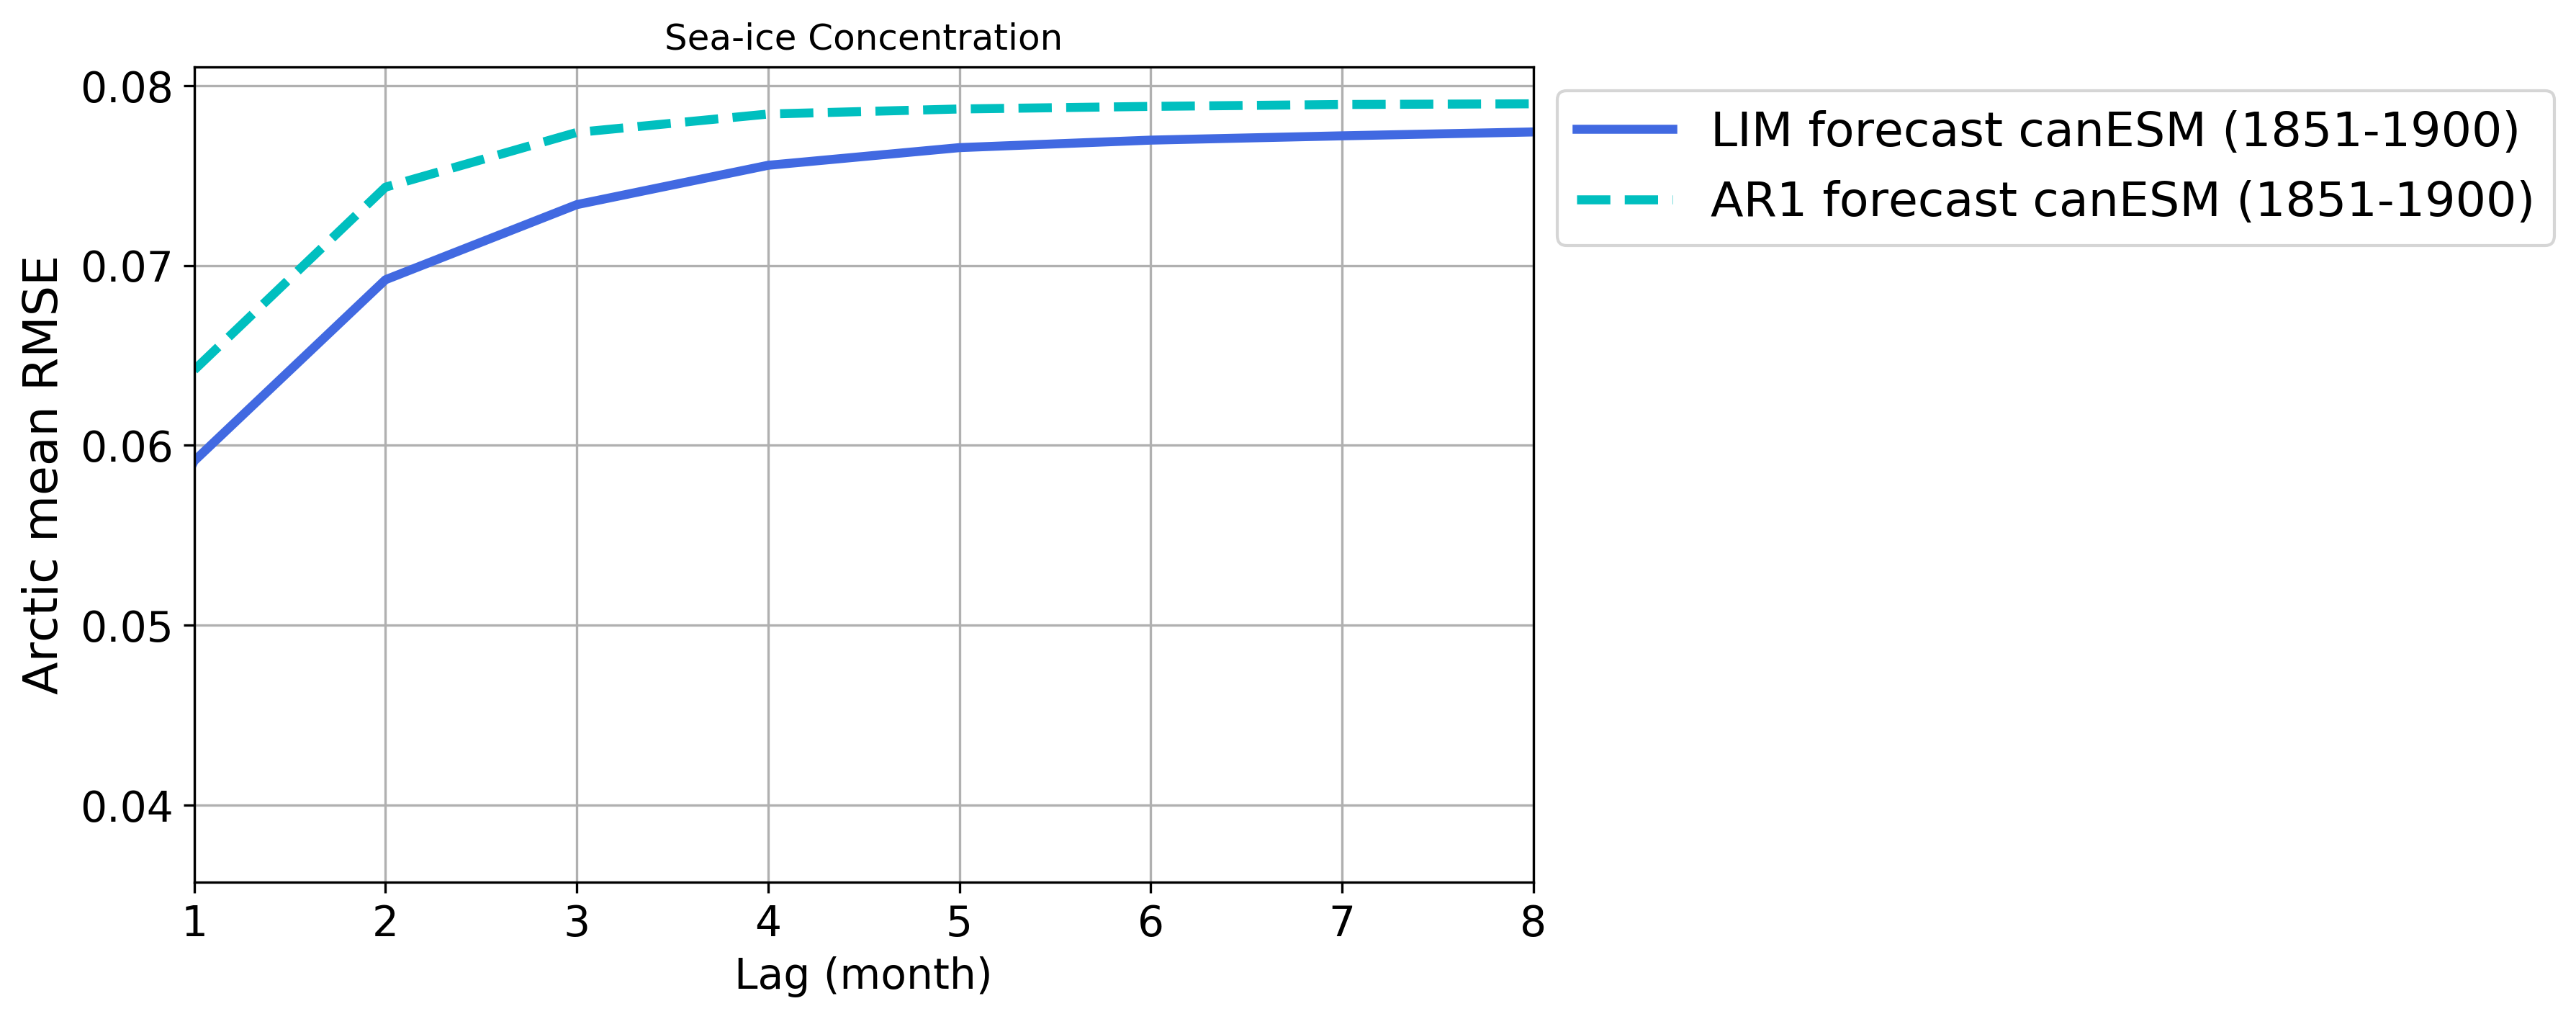

In [135]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_online['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast canESM (1851-1900)', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_online['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast canESM (1851-1900)', color='c', linewidth=3, linestyle='--')

#plt.ylim(0.08,0.1)
plt.xlim(1,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Arctic mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

Text(0.5, 1.0, 'Sea-ice Concentration')

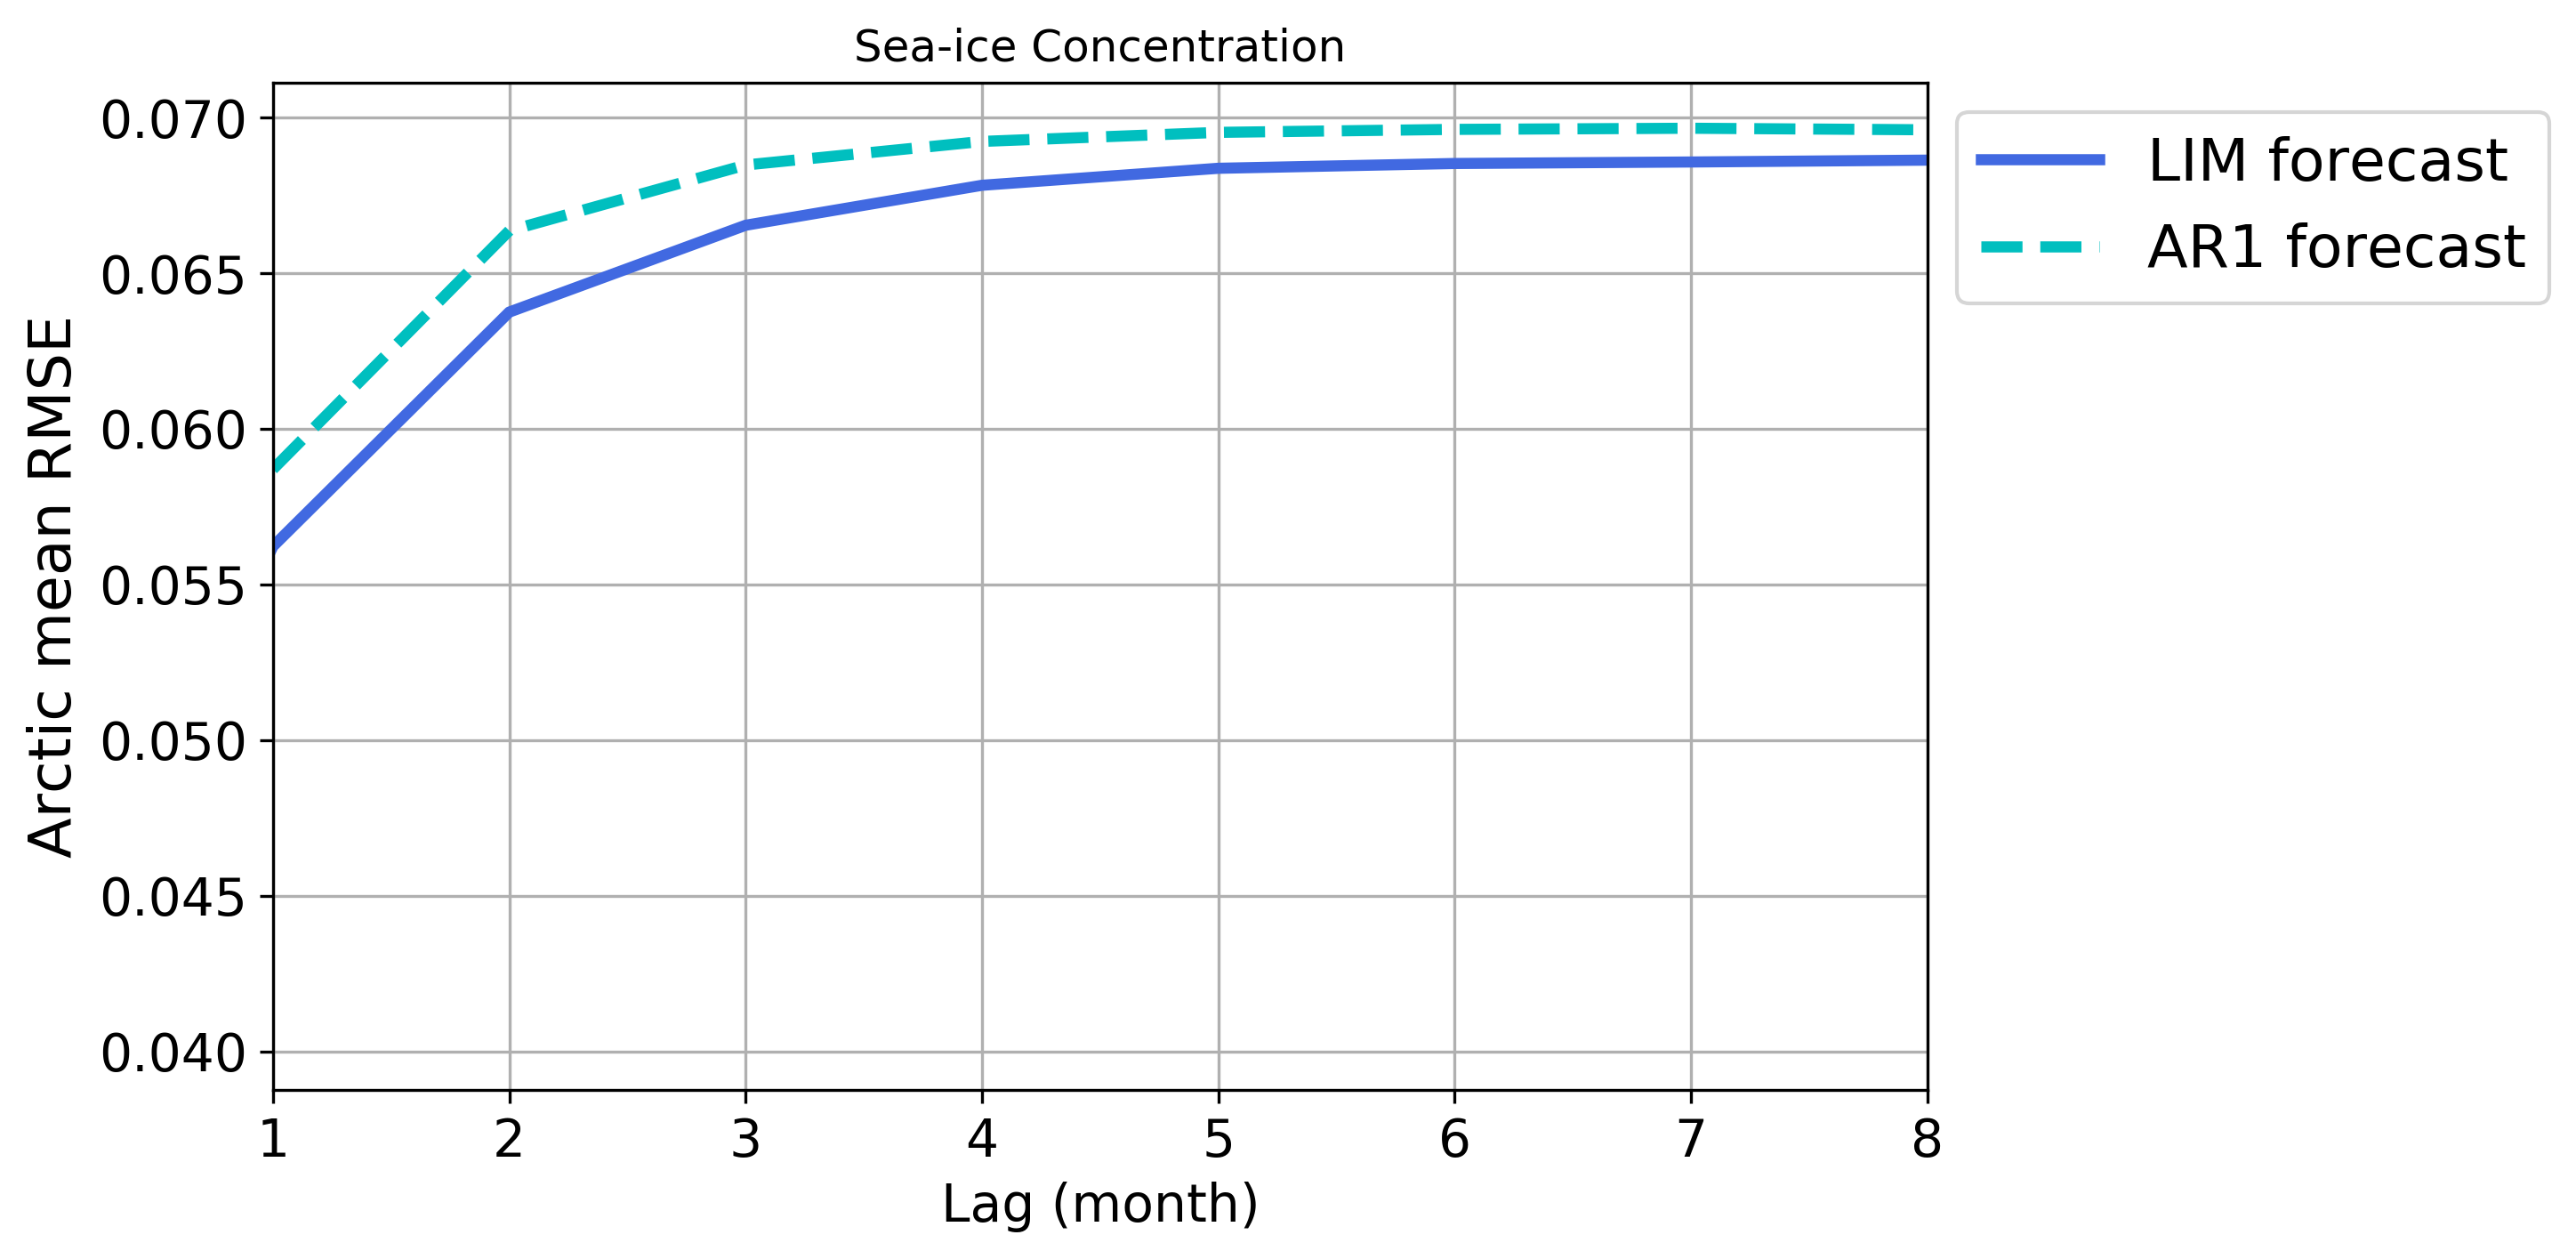

In [136]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_multimod1['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_multimod1['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast', color='c', linewidth=3, linestyle='--')

#plt.ylim(0.08,0.1)
plt.xlim(1,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Arctic mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

In [64]:
var_labels = {'tas':'Temperature (K)','tos':'Sea Surface Temperature (K)','zg':'Geopotential Height (500 hPa) (m)','psl':'Sea Level Pressure (Pa)','sit':'Sea Ice Thickness (m)','sic':'Sea Ice Concentration (%)'}

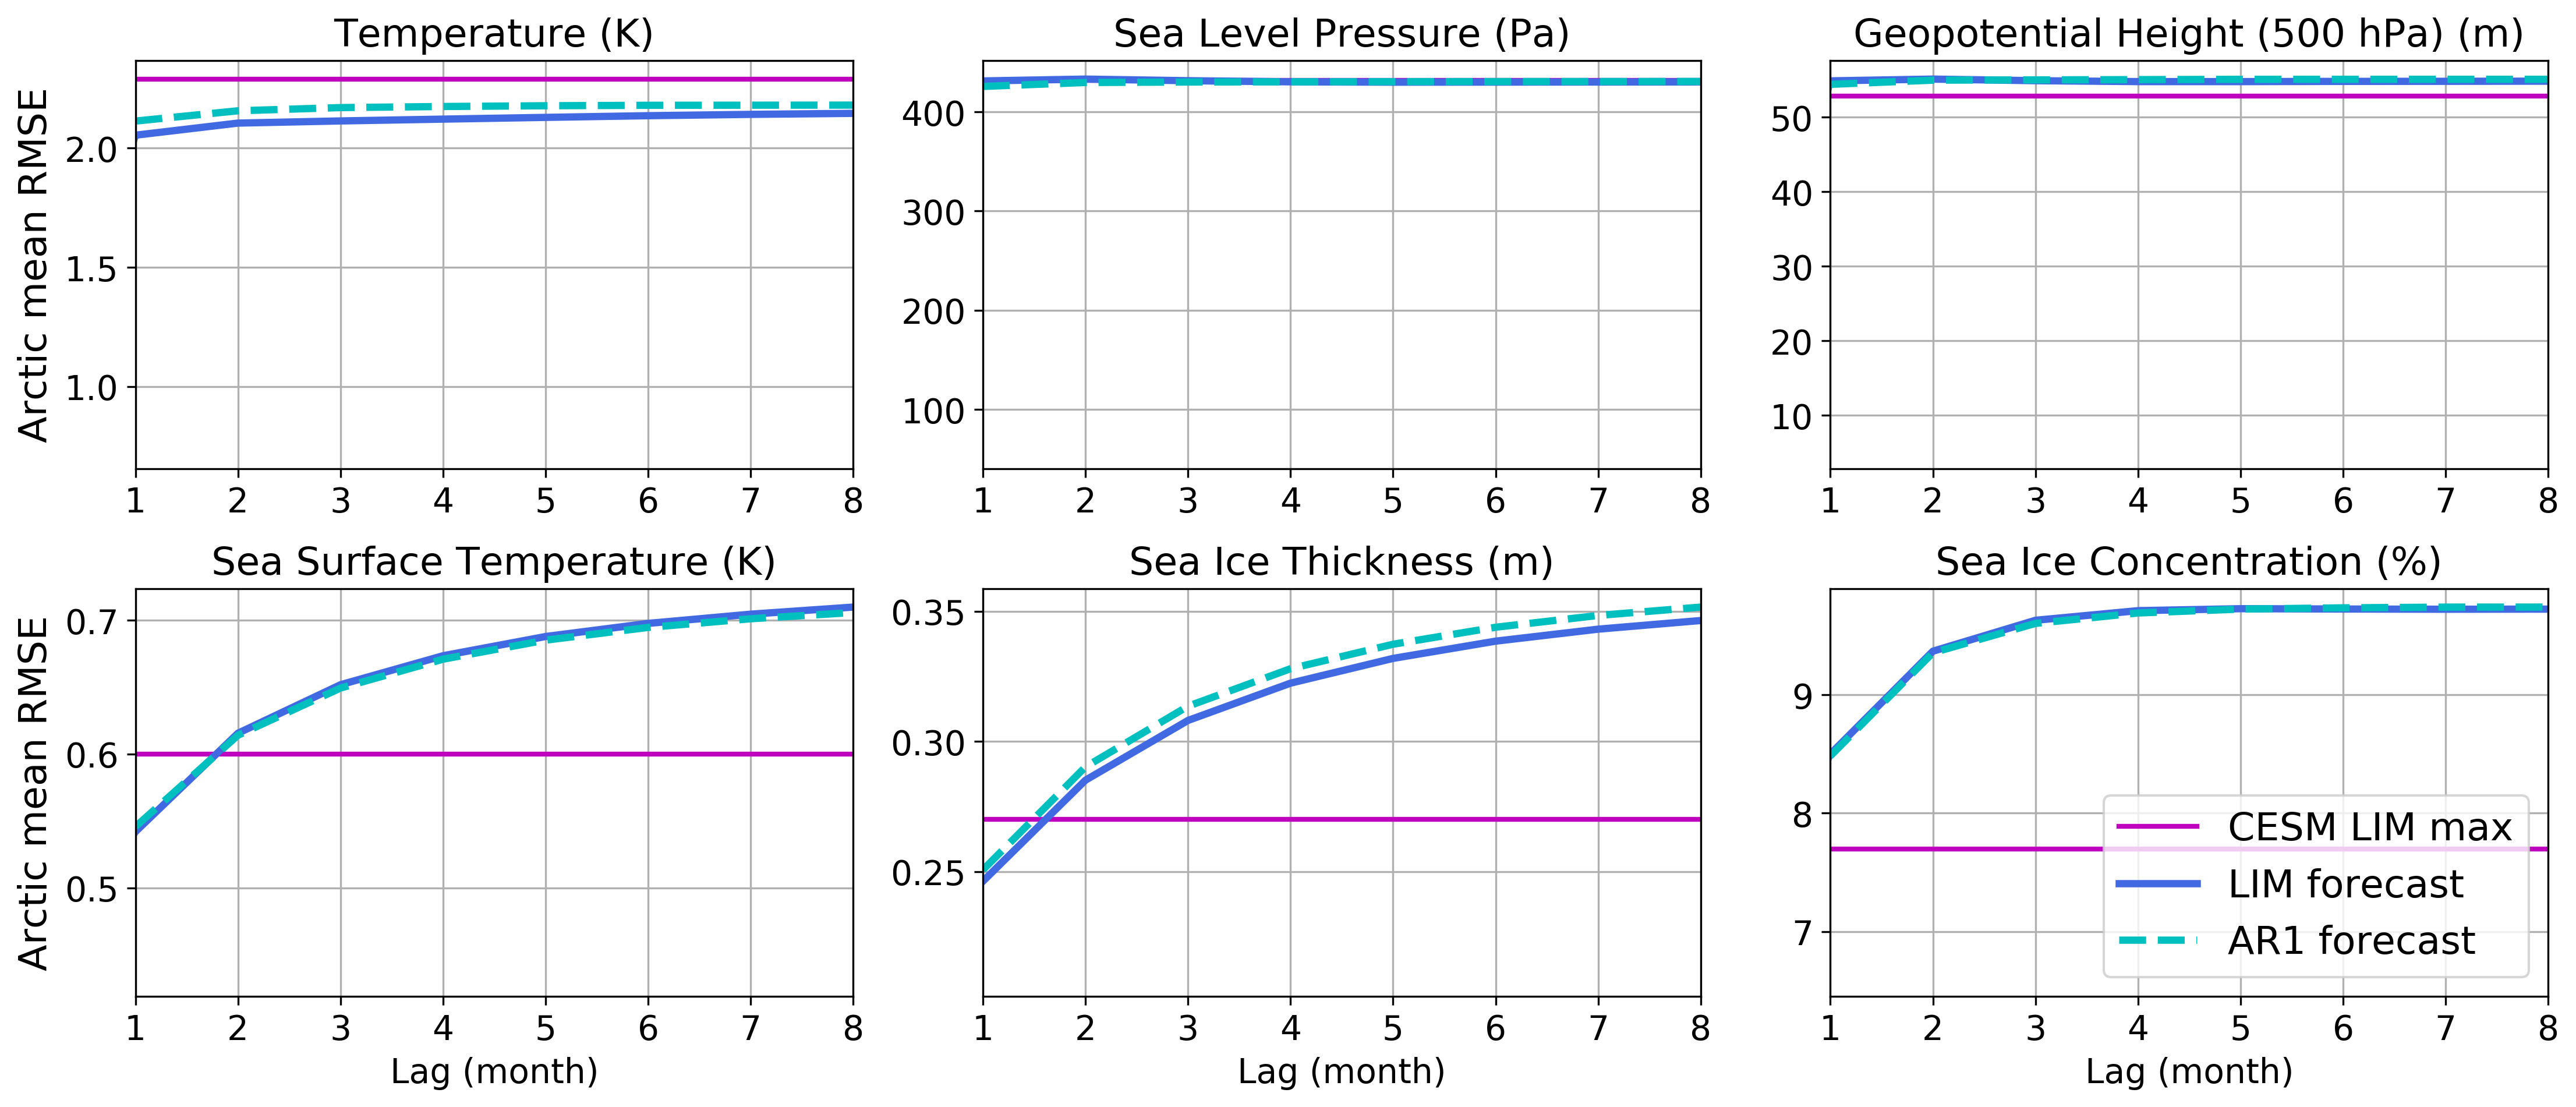

In [65]:
# ymin = [1.1,200,24,0.3,0.12, 5.0]
# ymax = [2.35,435,53.5,0.7,0.31, 8.1]
ymin = [2.0,410,51,0.3,0.12, 5]
ymax = [2.4,440,54,0.7,0.3, 8]
fig,axs = plt.subplots(2,3,figsize=(15,7))
ax = axs.flatten()

ax[0].axhline(2.29, color='m',linewidth=2)
ax[1].axhline(432, color='m',linewidth=2)
ax[2].axhline(52.8, color='m',linewidth=2)
ax[3].axhline(0.6, color='m',linewidth=2)
ax[4].axhline(0.27, color='m',linewidth=2)
ax[5].axhline(7.7, color='m',linewidth=2,label='CESM LIM max')

for i,var in enumerate(limvars): 
    ax[i].grid(axis='both')
    
    if 'sic' in var:
        ax[i].plot(np.arange(0,9,1),forecast_validation_lags_multimod1['validation_stats_lags'][var]['gm_rmse']*100, 
                 label='LIM forecast', color='royalblue', linewidth=3)
        ax[i].plot(np.arange(1,9,1),ar1cast_lags_multimod1['validation_stats_ar1_lags'][var]['gm_rmse'][:-1]*100, 
                 label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    else: 
        ax[i].plot(np.arange(0,9,1),forecast_validation_lags_multimod1['validation_stats_lags'][var]['gm_rmse'], 
                 label='LIM forecast', color='royalblue', linewidth=3)
        ax[i].plot(np.arange(1,9,1),ar1cast_lags_multimod1['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
                 label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    ax[i].set_xlim(1,8)
#    ax[i].set_ylim(ymin[i],ymax[i])
    ax[i].set_title(var_labels[var], fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    
ax[5].legend(loc='lower right',fontsize=16)

ax[3].set_xlabel('Lag (month)', fontsize=14)
ax[4].set_xlabel('Lag (month)', fontsize=14)
ax[5].set_xlabel('Lag (month)', fontsize=14)

ax[0].set_ylabel('Arctic mean RMSE',fontsize=16)
ax[3].set_ylabel('Arctic mean RMSE',fontsize=16)

ax[5].legend(loc='lower right',fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.suptitle('Out of Sample Validation: ', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# #plt.ylim(0.08,0.1)
# plt.xlim(1,8)
# #plt.ylim(1.75,1.95)
# plt.xlabel('Lag (month)', fontsize=14)
# plt.ylabel('Arctic mean RMSE',fontsize=16)
# #ax.set_xticks(ticks=np.arange(0,13,1))
# plt.yticks(fontsize=14)
# plt.xticks(fontsize=14)
# plt.legend(bbox_to_anchor=[1,1],fontsize=16)
# plt.title('Sea-ice Concentration')

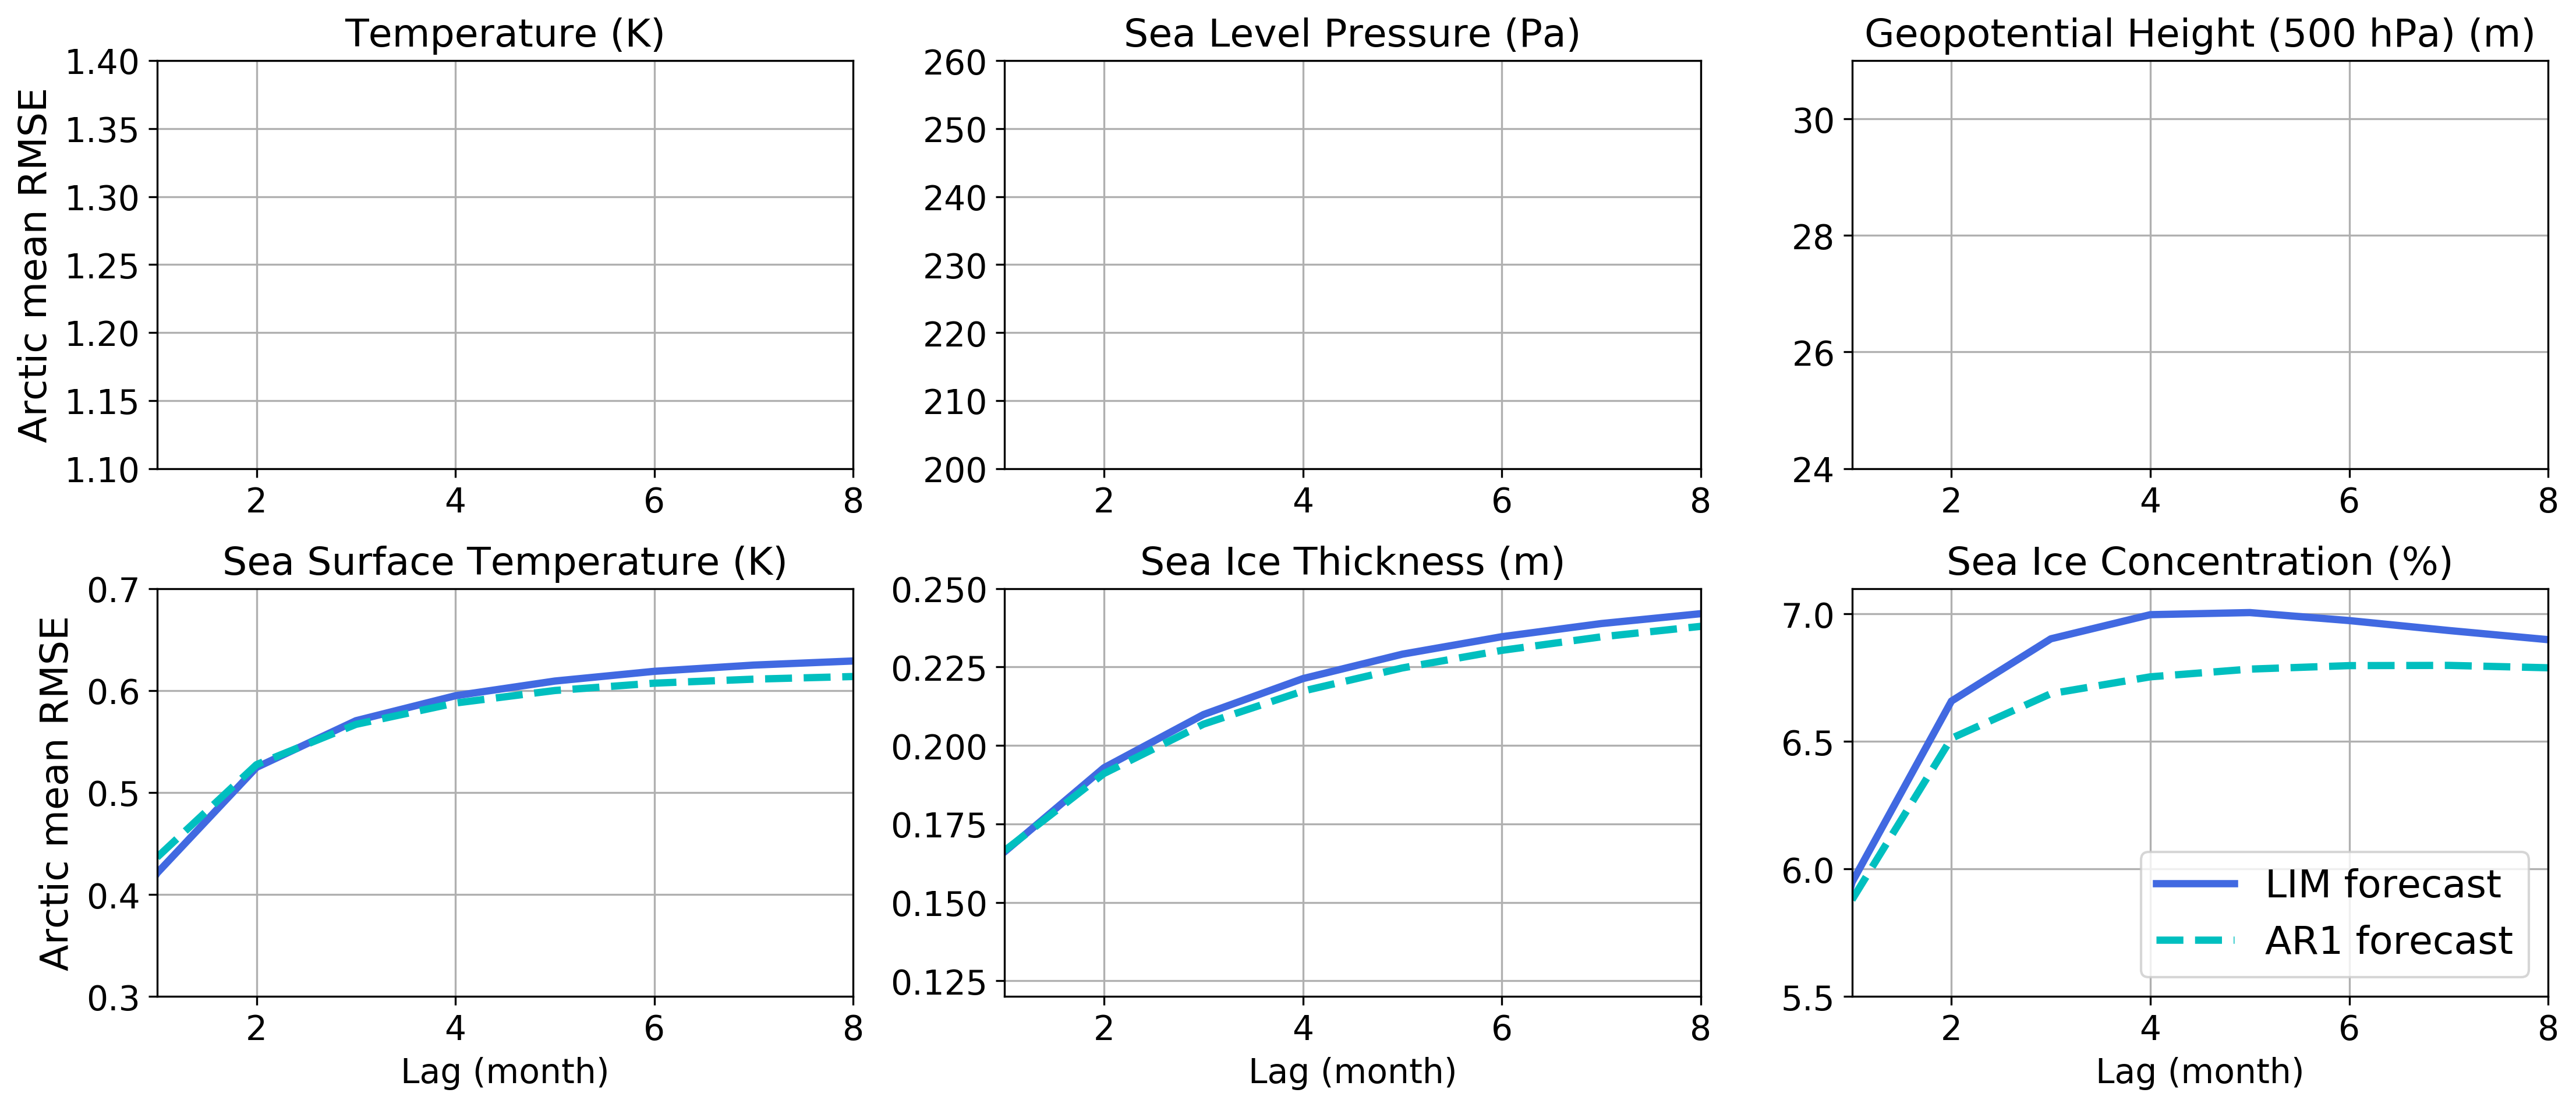

In [34]:
# ymin = [1.1,200,24,0.3,0.12, 5.0]
# ymax = [2.35,435,53.5,0.7,0.31, 8.1]
ymin = [1.1,200,24,0.3,0.12, 5.5]
ymax = [1.4,260,31,0.7,0.25, 7.1]
fig,axs = plt.subplots(2,3,figsize=(15,7))
ax = axs.flatten()

# ax[0].axhline(2.31, color='m',linewidth=2)
# ax[1].axhline(432, color='m',linewidth=2)
# ax[2].axhline(52.8, color='m',linewidth=2)
# ax[3].axhline(0.6, color='m',linewidth=2)
# ax[4].axhline(0.27, color='m',linewidth=2)
# ax[5].axhline(7.8, color='m',linewidth=2, label='CESM LIM max')

for i,var in enumerate(limvars): 
    ax[i].grid(axis='both')
    
    if 'sic' in var:
        ax[i].plot(np.arange(0,9,1),forecast_validation_lags_multimod1['validation_stats_lags'][var]['gm_rmse']*100, 
                 label='LIM forecast', color='royalblue', linewidth=3)
        ax[i].plot(np.arange(1,9,1),ar1cast_lags_multimod1['validation_stats_ar1_lags'][var]['gm_rmse'][:-1]*100, 
                 label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    else: 
        ax[i].plot(np.arange(0,9,1),forecast_validation_lags_multimod1['validation_stats_lags'][var]['gm_rmse'], 
                 label='LIM forecast', color='royalblue', linewidth=3)
        ax[i].plot(np.arange(1,9,1),ar1cast_lags_multimod1['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
                 label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    ax[i].set_xlim(1,8)
    ax[i].set_ylim(ymin[i],ymax[i])
    ax[i].set_title(var_labels[var], fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    
ax[5].legend(loc='lower right',fontsize=16)

ax[3].set_xlabel('Lag (month)', fontsize=14)
ax[4].set_xlabel('Lag (month)', fontsize=14)
ax[5].set_xlabel('Lag (month)', fontsize=14)

ax[0].set_ylabel('Arctic mean RMSE',fontsize=16)
ax[3].set_ylabel('Arctic mean RMSE',fontsize=16)

ax[5].legend(loc='lower right',fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.suptitle('Out of Sample Validation: ', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Text(0, 0.5, 'Arctic mean RMSE')

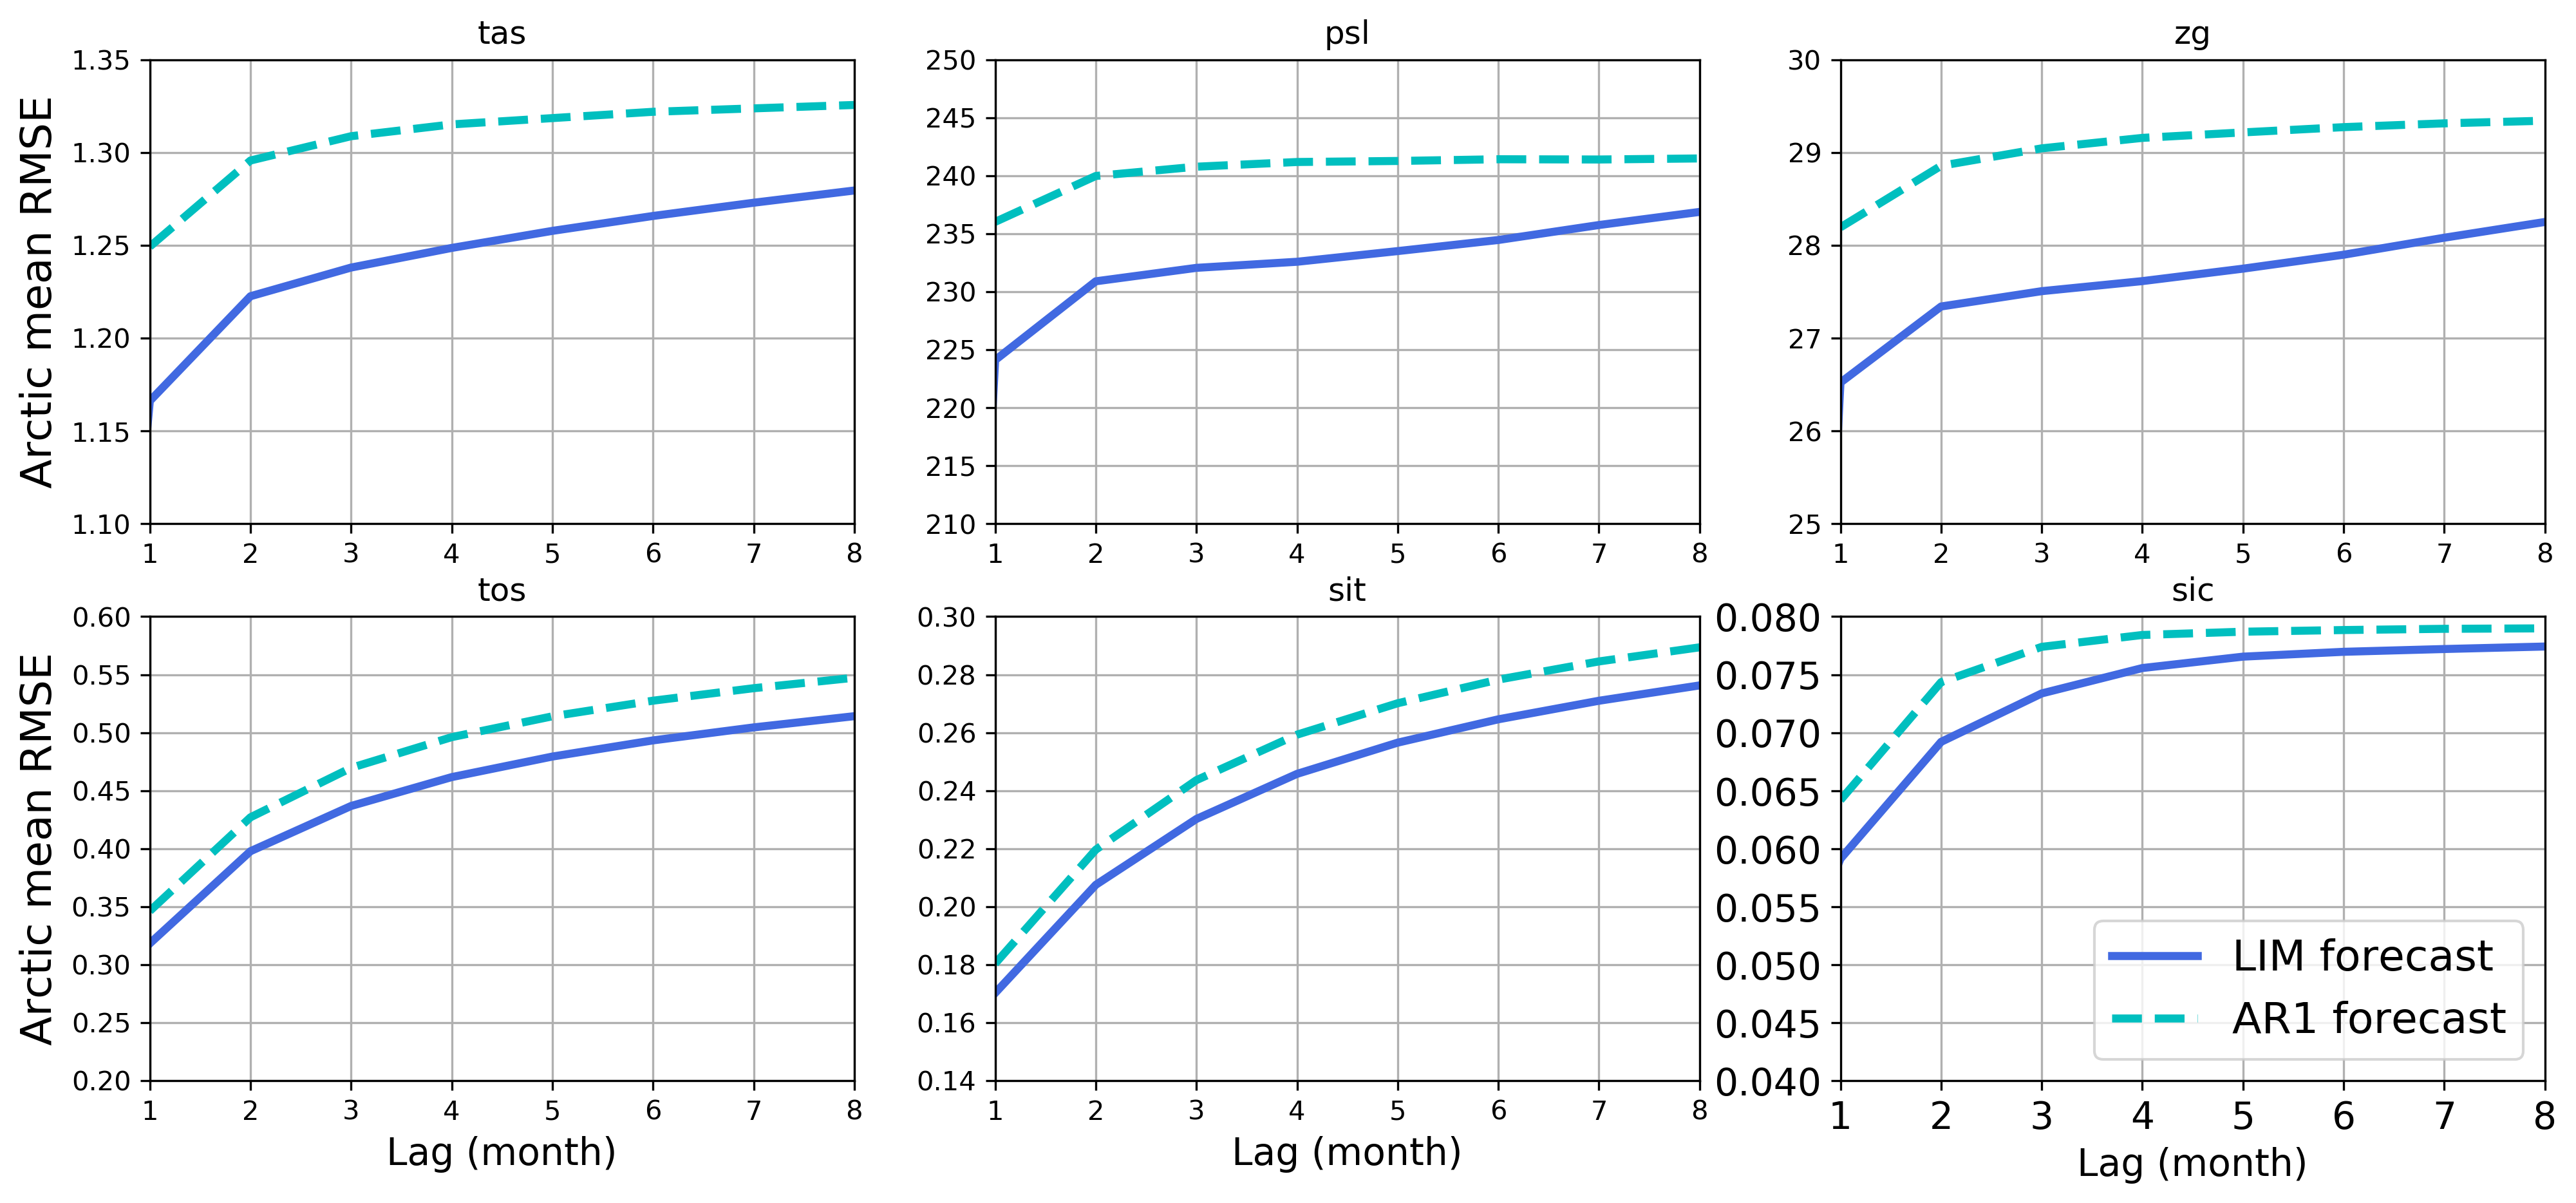

In [36]:
ymin = [1.1,210,25,0.2,0.14,0.04]
ymax = [1.35,250,30,0.6,0.3,0.08]
fig,axs = plt.subplots(2,3,figsize=(16,7))
ax = axs.flatten()

for i,var in enumerate(limvars): 
    ax[i].plot(np.arange(0,9,1),forecast_validation_lags_online['validation_stats_lags'][var]['gm_rmse'], 
             label='LIM forecast', color='royalblue', linewidth=3)
    ax[i].plot(np.arange(1,9,1),ar1cast_lags_online['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
             label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    ax[i].set_xlim(1,8)
    ax[i].set_ylim(ymin[i],ymax[i])
    ax[i].set_title(var)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    ax[i].grid(axis='both')
    
ax[5].legend(loc='lower right',fontsize=16)

ax[3].set_xlabel('Lag (month)', fontsize=14)
ax[4].set_xlabel('Lag (month)', fontsize=14)
ax[5].set_xlabel('Lag (month)', fontsize=14)

ax[0].set_ylabel('Arctic mean RMSE',fontsize=16)
ax[3].set_ylabel('Arctic mean RMSE',fontsize=16)

# #plt.ylim(0.08,0.1)
# plt.xlim(1,8)
# #plt.ylim(1.75,1.95)
# plt.xlabel('Lag (month)', fontsize=14)
# plt.ylabel('Arctic mean RMSE',fontsize=16)
# #ax.set_xticks(ticks=np.arange(0,13,1))
# plt.yticks(fontsize=14)
# plt.xticks(fontsize=14)
# plt.legend(bbox_to_anchor=[1,1],fontsize=16)
# plt.title('Sea-ice Concentration')

Text(0.5, 1.0, 'Sea-ice Concentration')

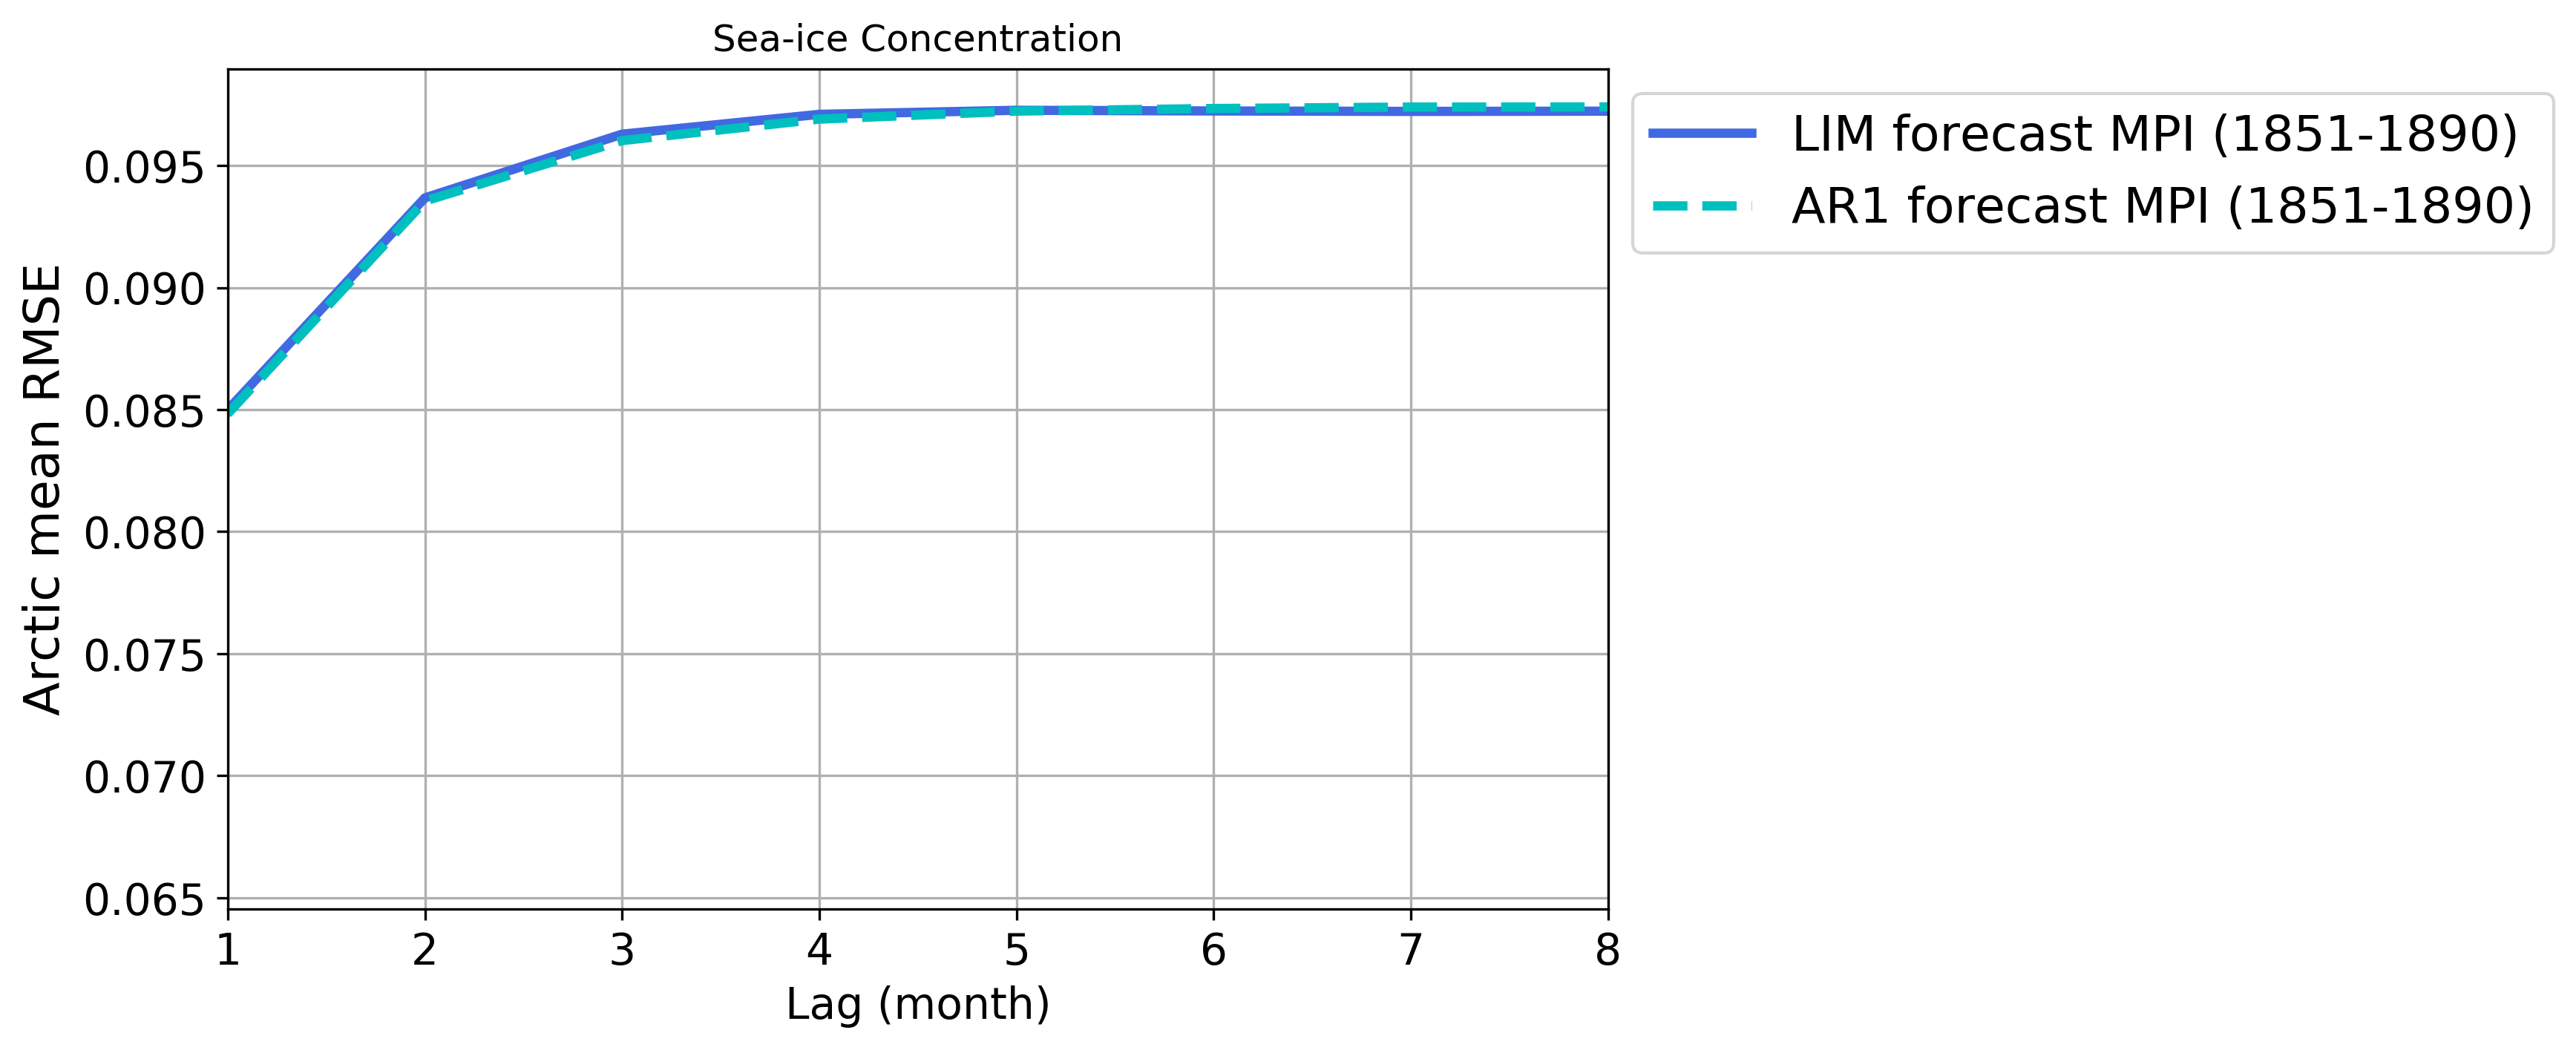

In [155]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_multimod1['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast MPI (1851-1890)', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_multimod1['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast MPI (1851-1890)', color='c', linewidth=3, linestyle='--')

#plt.ylim(0.08,0.1)
plt.xlim(1,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Arctic mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

Text(0.5, 1.0, 'Sea-ice Concentration')

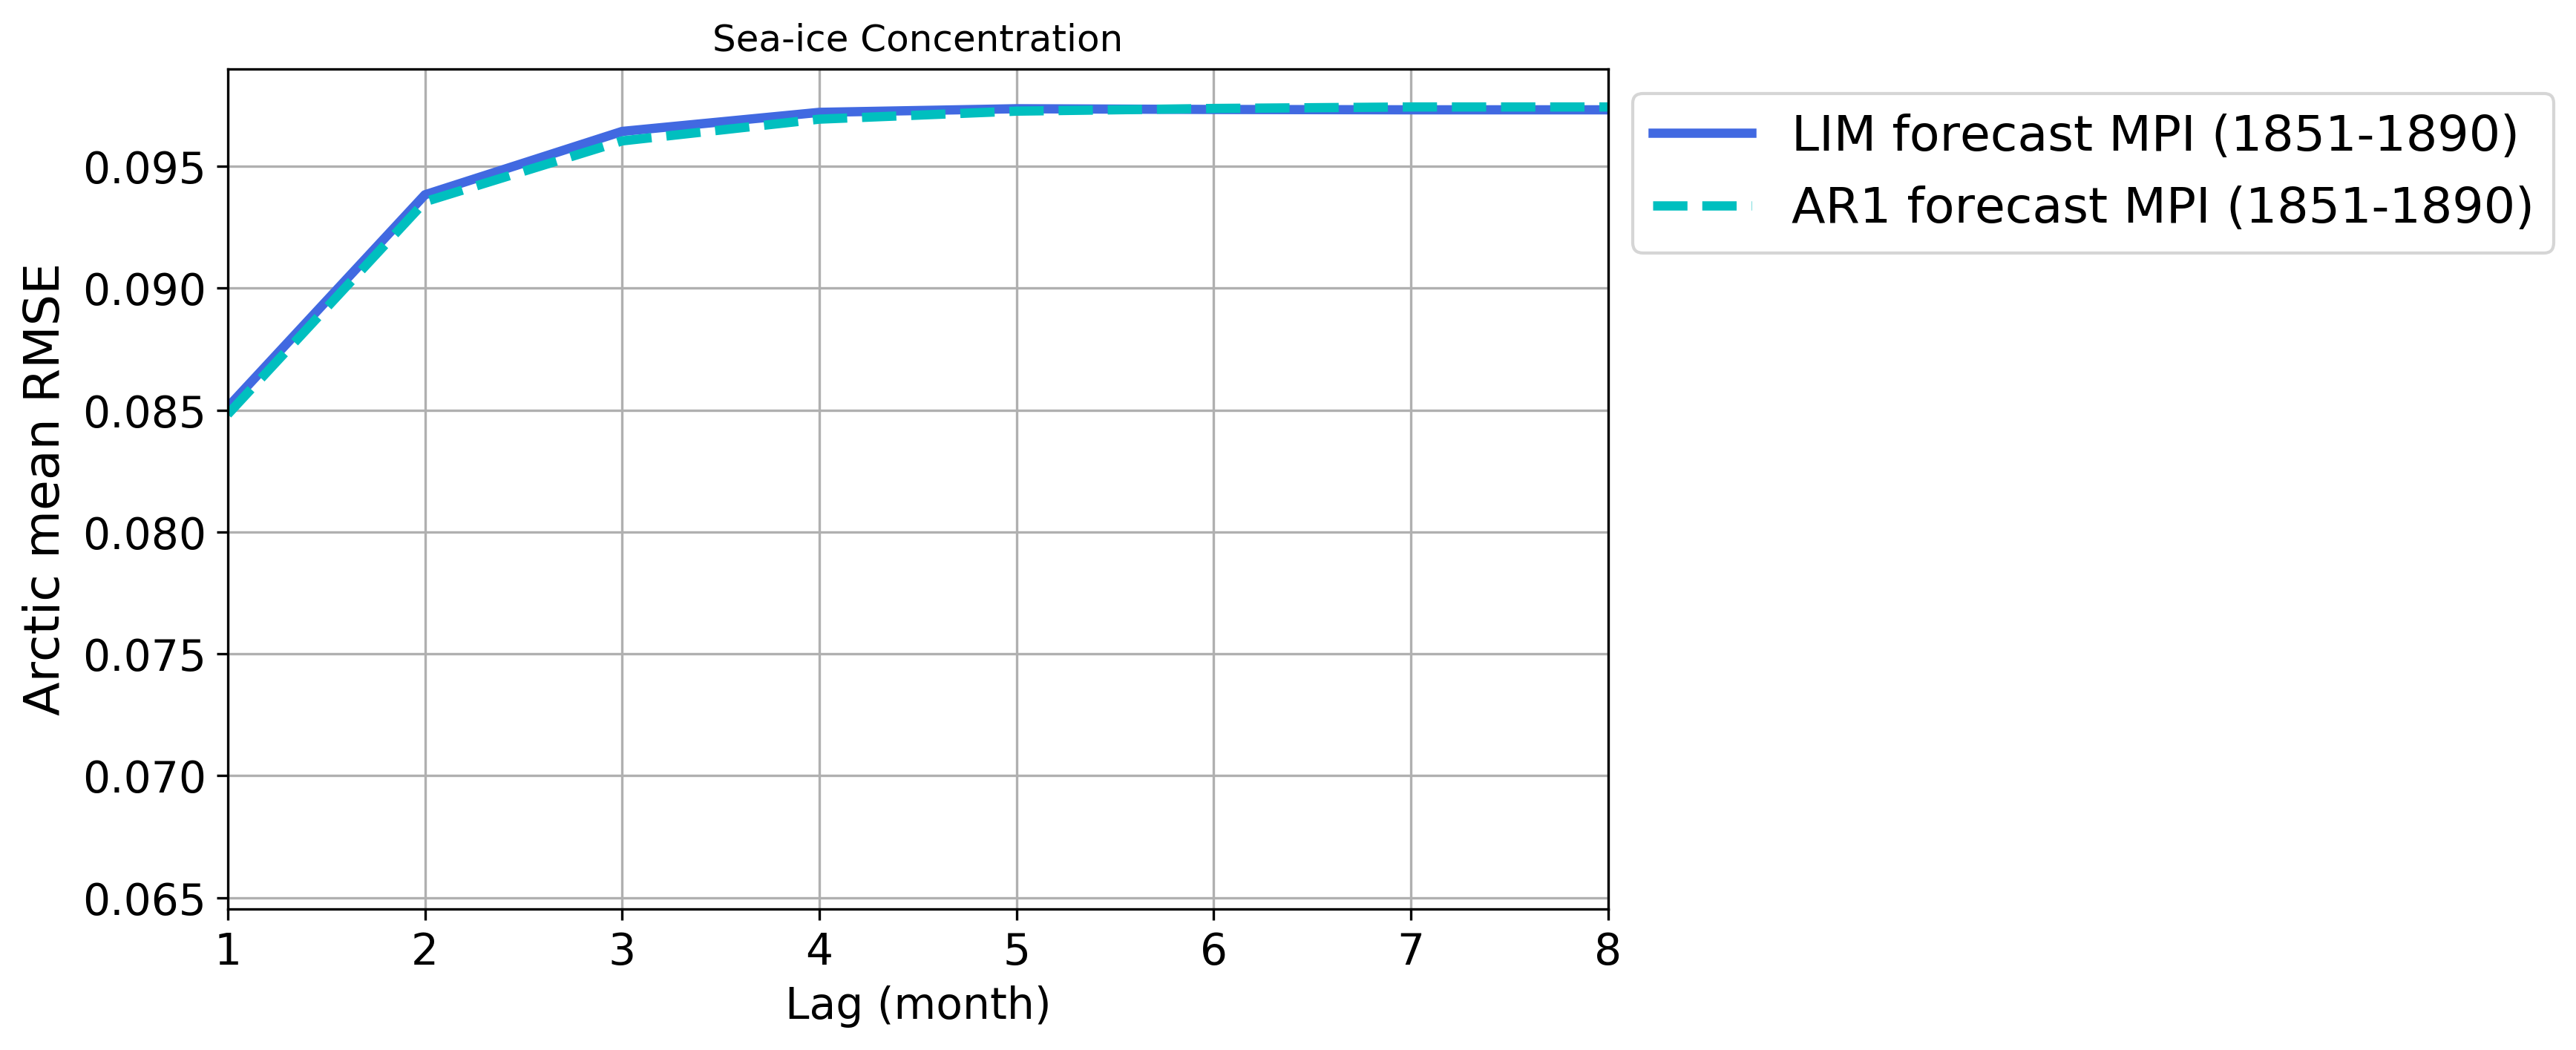

In [156]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_multimod2['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast MPI (1851-1890)', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_multimod2['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast MPI (1851-1890)', color='c', linewidth=3, linestyle='--')

#plt.ylim(0.08,0.1)
plt.xlim(1,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Arctic mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

Text(0.5, 1.0, 'Sea-ice Concentration')

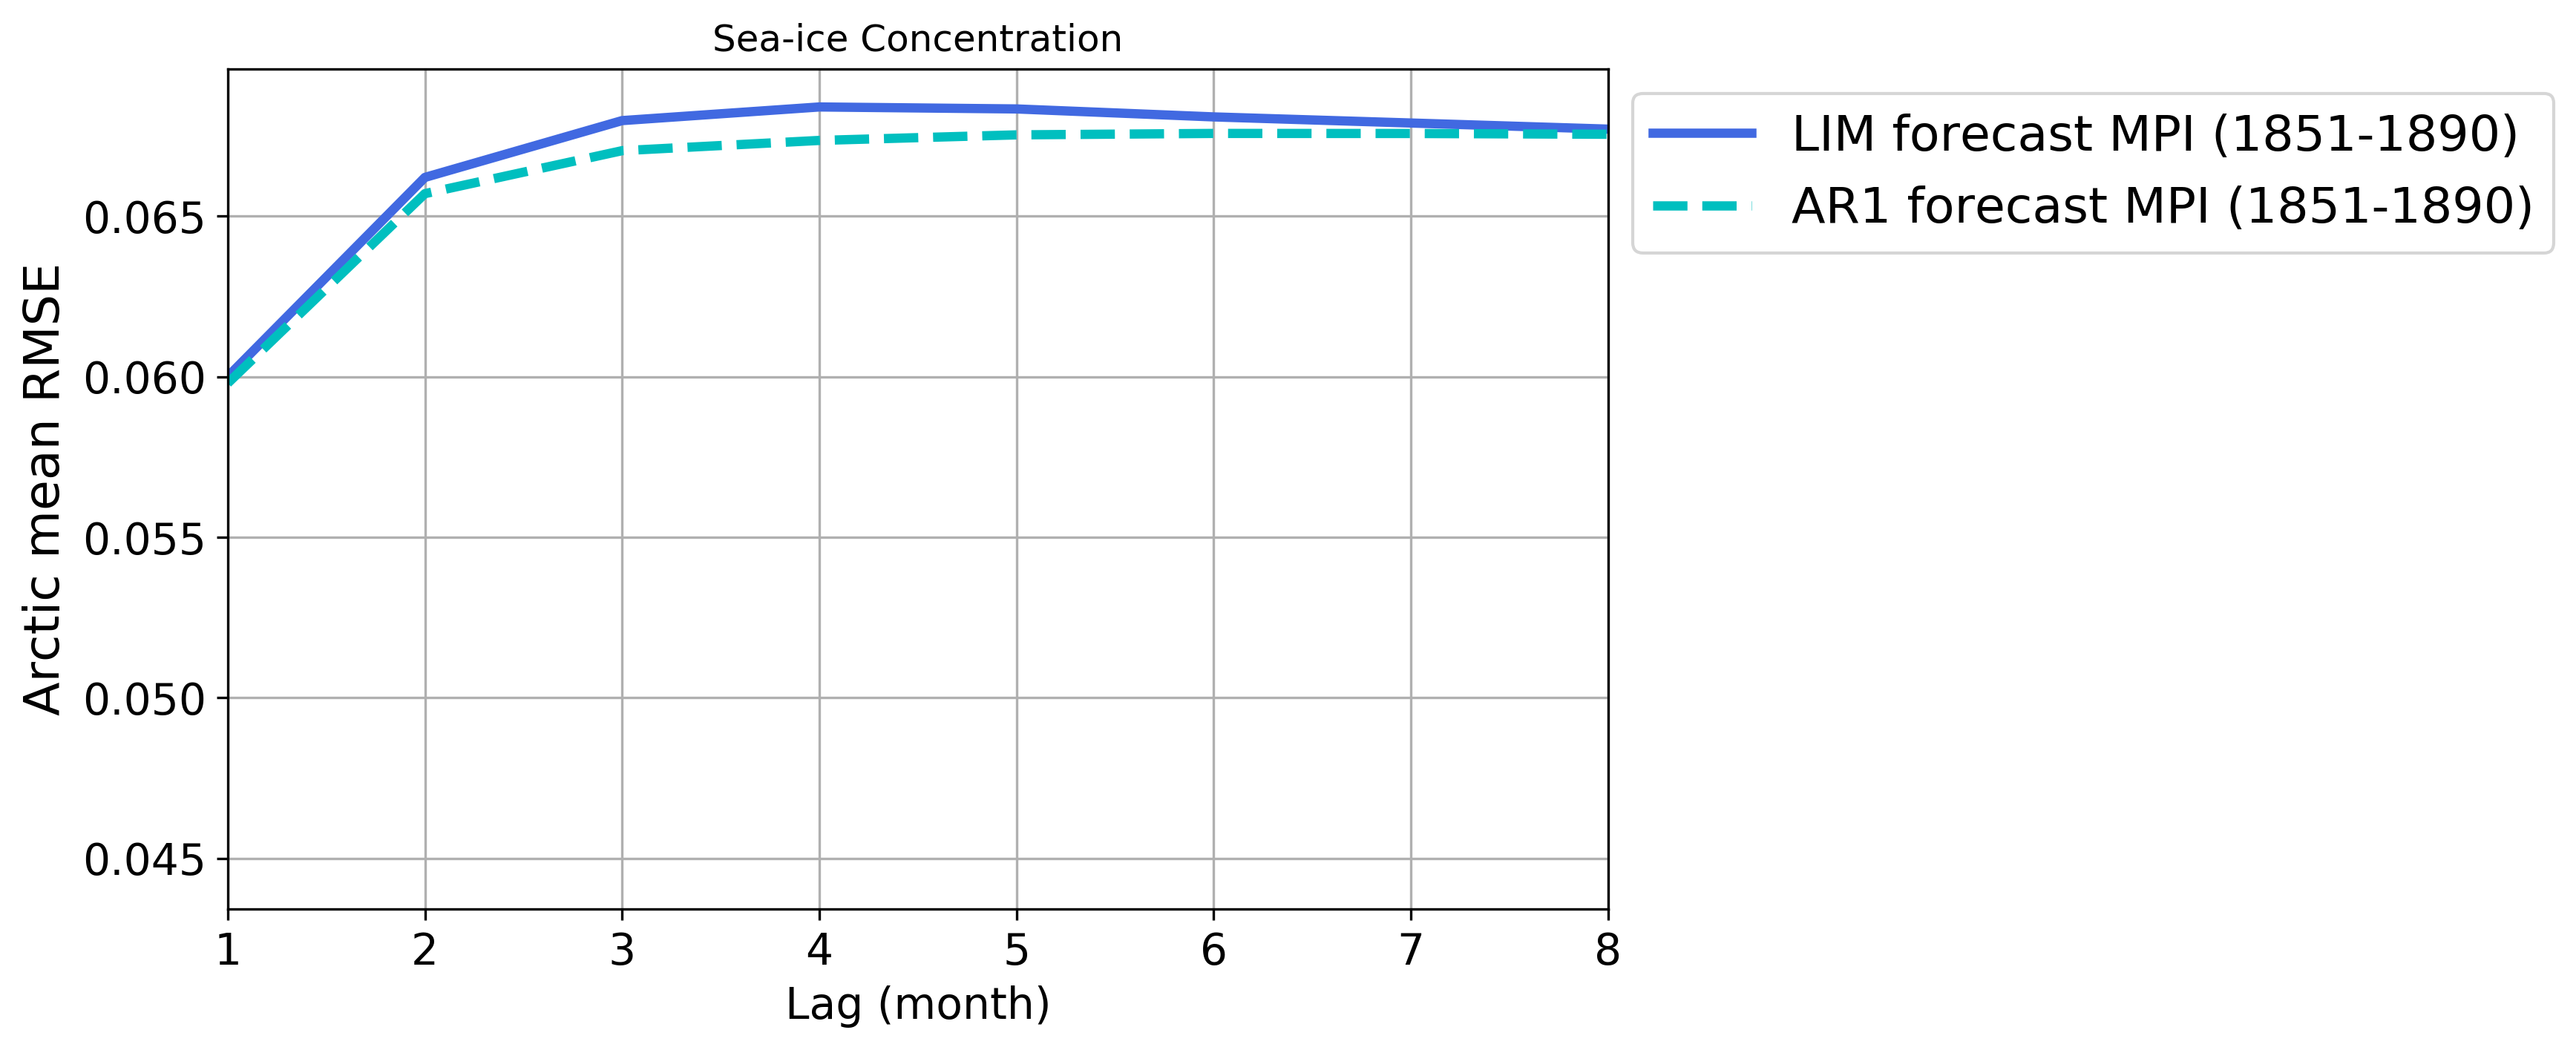

In [116]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_multimod3['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast MPI (1851-1890)', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_multimod3['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast MPI (1851-1890)', color='c', linewidth=3, linestyle='--')

#plt.ylim(0.08,0.1)
plt.xlim(1,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Arctic mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

Text(0.5, 1.0, 'Sea-ice Concentration')

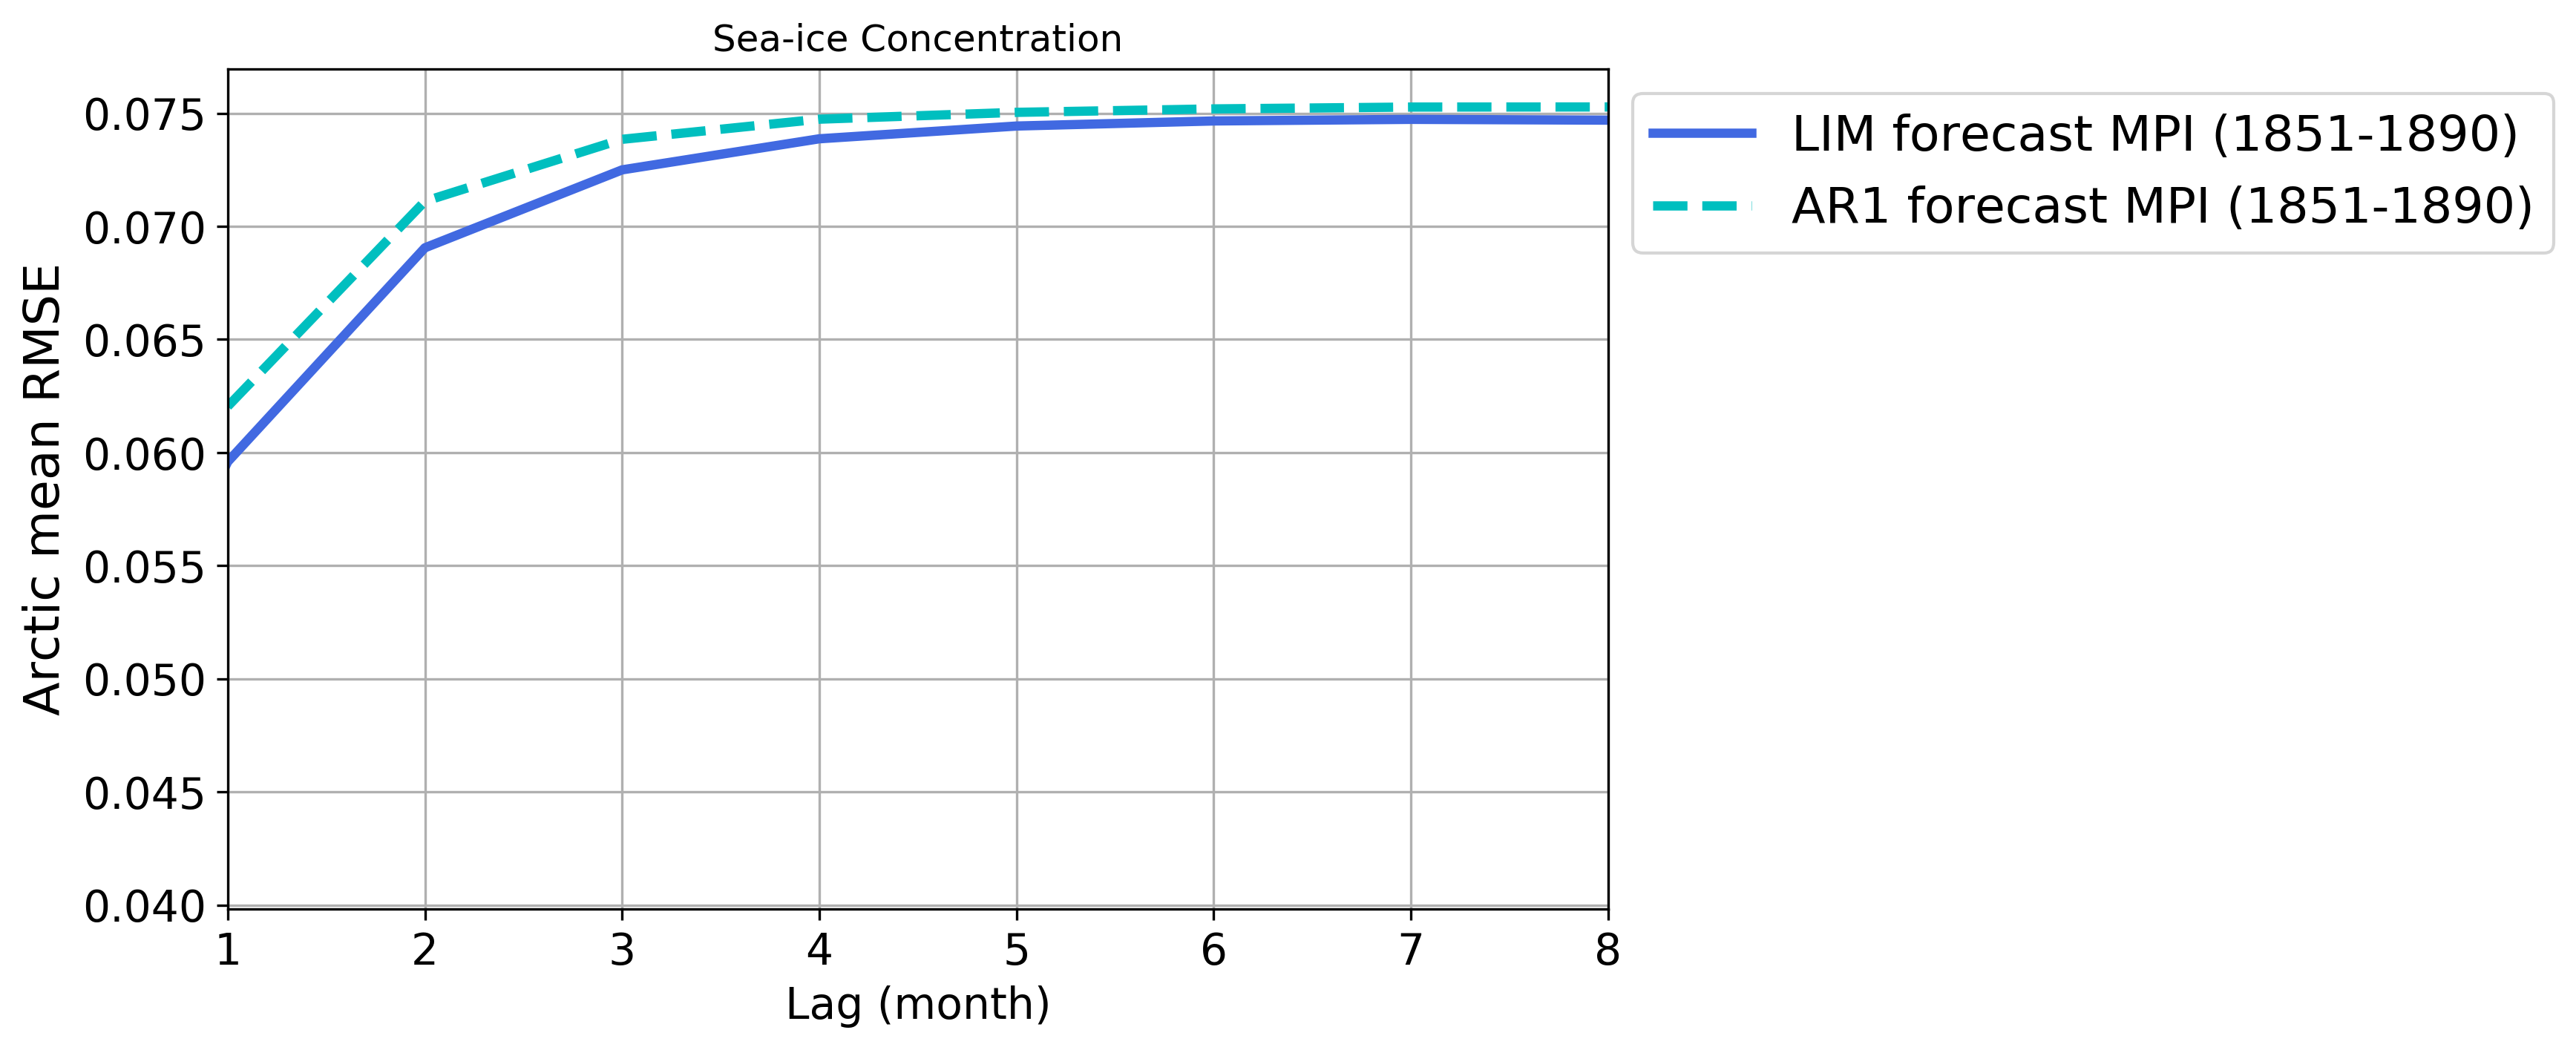

In [100]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_multimod4['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast MPI (1851-1890)', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_multimod4['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast MPI (1851-1890)', color='c', linewidth=3, linestyle='--')

#plt.ylim(0.08,0.1)
plt.xlim(1,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Arctic mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

Text(0.5, 1.0, 'Sea-ice Concentration')

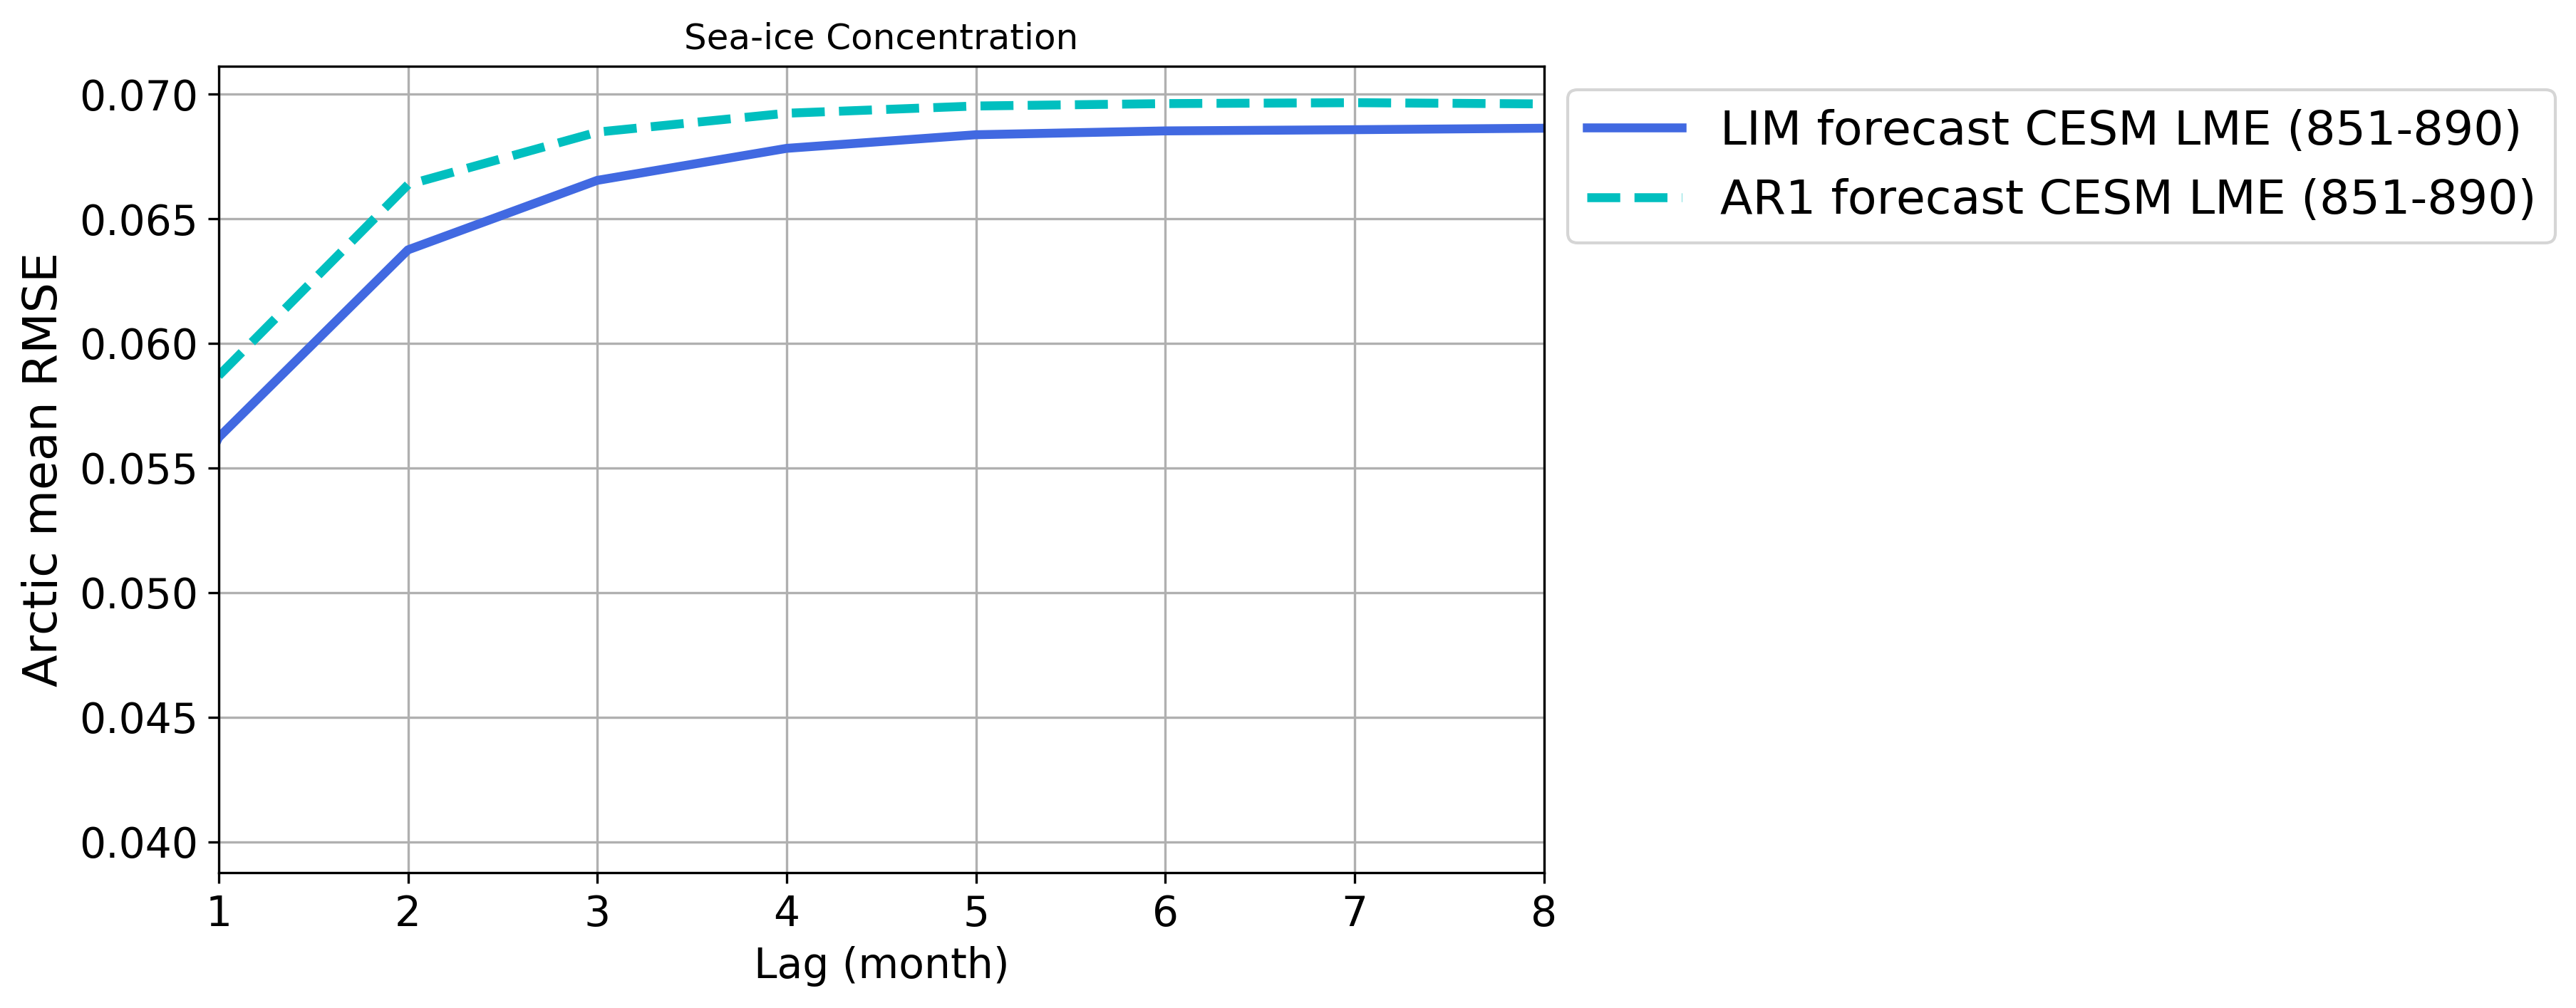

In [101]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_multimod5['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast CESM LME (851-890)', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_multimod5['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast CESM LME (851-890)', color='c', linewidth=3, linestyle='--')

#plt.ylim(0.08,0.1)
plt.xlim(1,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Arctic mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

Text(0.5, 1.0, 'Sea-ice Concentration')

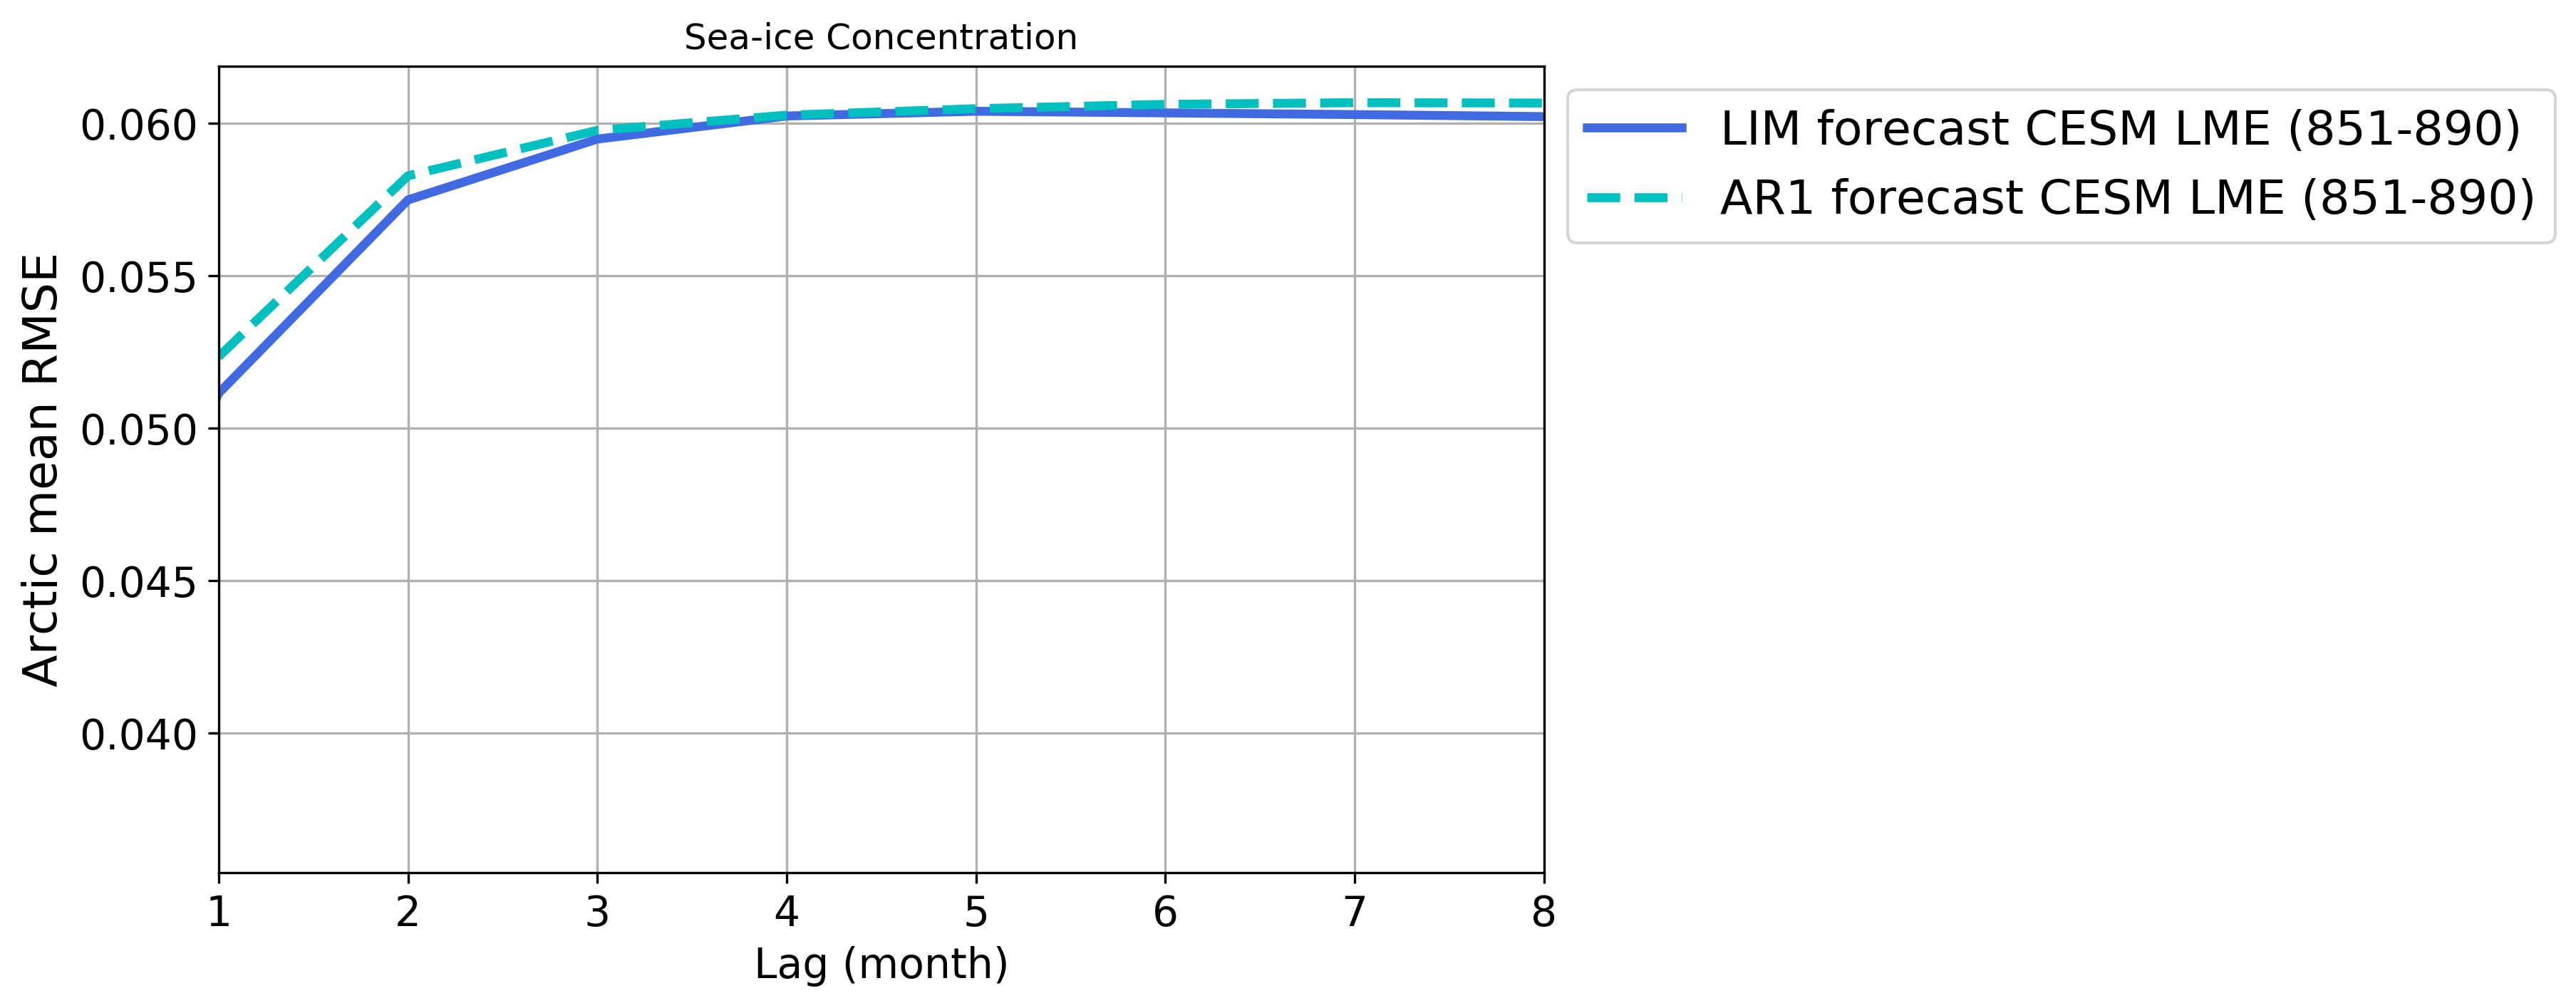

In [102]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_multimod6['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast CESM LME (851-890)', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_multimod6['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast CESM LME (851-890)', color='c', linewidth=3, linestyle='--')

#plt.ylim(0.08,0.1)
plt.xlim(1,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Arctic mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

Text(0, 0.5, 'Arctic mean RMSE')

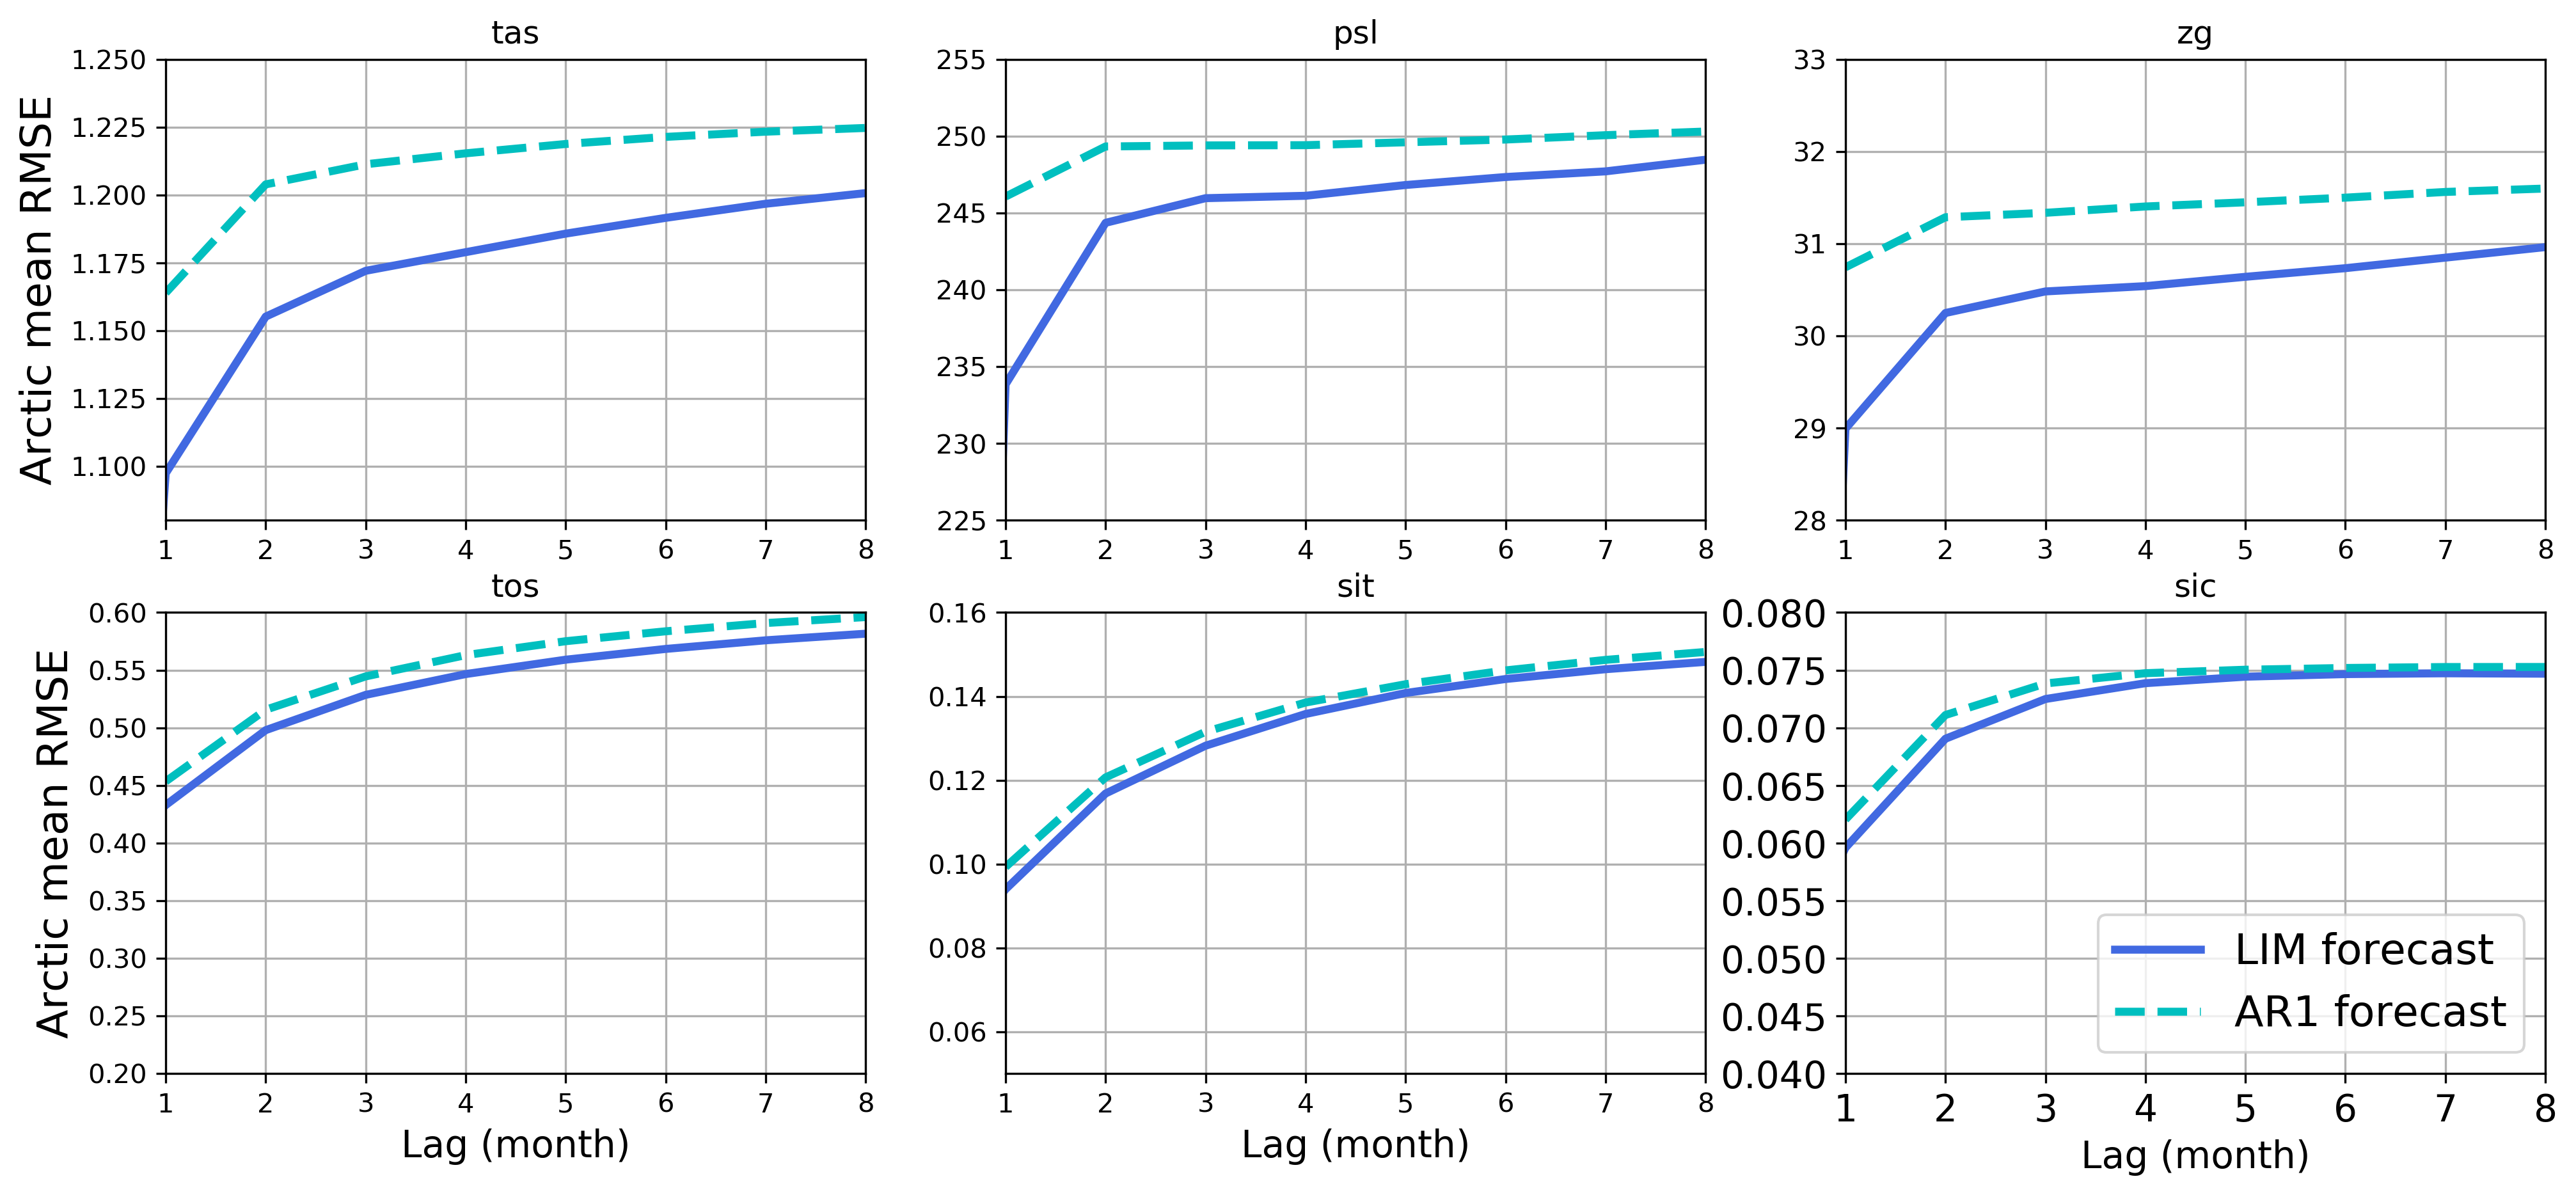

In [103]:
ymin = [1.08,225,28,0.2,0.05,0.04]
ymax = [1.25,255,33,0.6,0.16,0.08]
fig,axs = plt.subplots(2,3,figsize=(16,7))
ax = axs.flatten()

for i,var in enumerate(limvars): 
    ax[i].plot(np.arange(0,9,1),forecast_validation_lags_multimod4['validation_stats_lags'][var]['gm_rmse'], 
             label='LIM forecast', color='royalblue', linewidth=3)
    ax[i].plot(np.arange(1,9,1),ar1cast_lags_multimod4['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
             label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    ax[i].set_xlim(1,8)
    ax[i].set_ylim(ymin[i],ymax[i])
    ax[i].set_title(var)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    ax[i].grid(axis='both')
    
ax[5].legend(loc='lower right',fontsize=16)

ax[3].set_xlabel('Lag (month)', fontsize=14)
ax[4].set_xlabel('Lag (month)', fontsize=14)
ax[5].set_xlabel('Lag (month)', fontsize=14)

ax[0].set_ylabel('Arctic mean RMSE',fontsize=16)
ax[3].set_ylabel('Arctic mean RMSE',fontsize=16)

In [44]:
experiment_canESM =  pickle.load(open(data_dir+filename_multimod1, 'rb'))
experiment_canESM2 =  pickle.load(open(data_dir+filename_multimod2, 'rb'))
experiment_era5 =  pickle.load(open(data_dir+filename_multimod3, 'rb'))

In [45]:
LIMd_canESM  = experiment_canESM ['LIMd']
exp_setup_canESM  = experiment_canESM['forecast']['exp_setup']
forecast_canESM  = experiment_canESM['forecast']
forecast_validation_lags_canESM = experiment_canESM['forecast_validation_lags']
ar1cast_lags_canESM = experiment_canESM['ar1cast_lags']

In [46]:
LIMd_canESM2  = experiment_canESM2['LIMd']
exp_setup_canESM2  = experiment_canESM2['forecast']['exp_setup']
forecast_canESM2 = experiment_canESM2['forecast']
forecast_validation_lags_canESM2 = experiment_canESM2['forecast_validation_lags']
ar1cast_lags_canESM2 = experiment_canESM2['ar1cast_lags']

In [47]:
LIMd_era5  = experiment_era5['LIMd']
exp_setup_era5  = experiment_era5['forecast']['exp_setup']
forecast_era5  = experiment_era5['forecast']
forecast_validation_lags_era5 = experiment_era5['forecast_validation_lags']
ar1cast_lags_era5 = experiment_era5['ar1cast_lags']

In [36]:
forecast_validation_lags_canESM['validation_stats_lags']['sic']['gm_rmse'],ar1cast_lags_canESM['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]

(array([0.06609608, 0.08499039, 0.09367598, 0.09628758, 0.09709929,
        0.09726582, 0.09723726, 0.0972193 , 0.09722883]),
 array([0.08483034, 0.09354716, 0.09602359, 0.09690355, 0.09723131,
        0.09733797, 0.09739755, 0.09740152]))

Text(0.5, 1.0, 'Sea-ice Concentration')

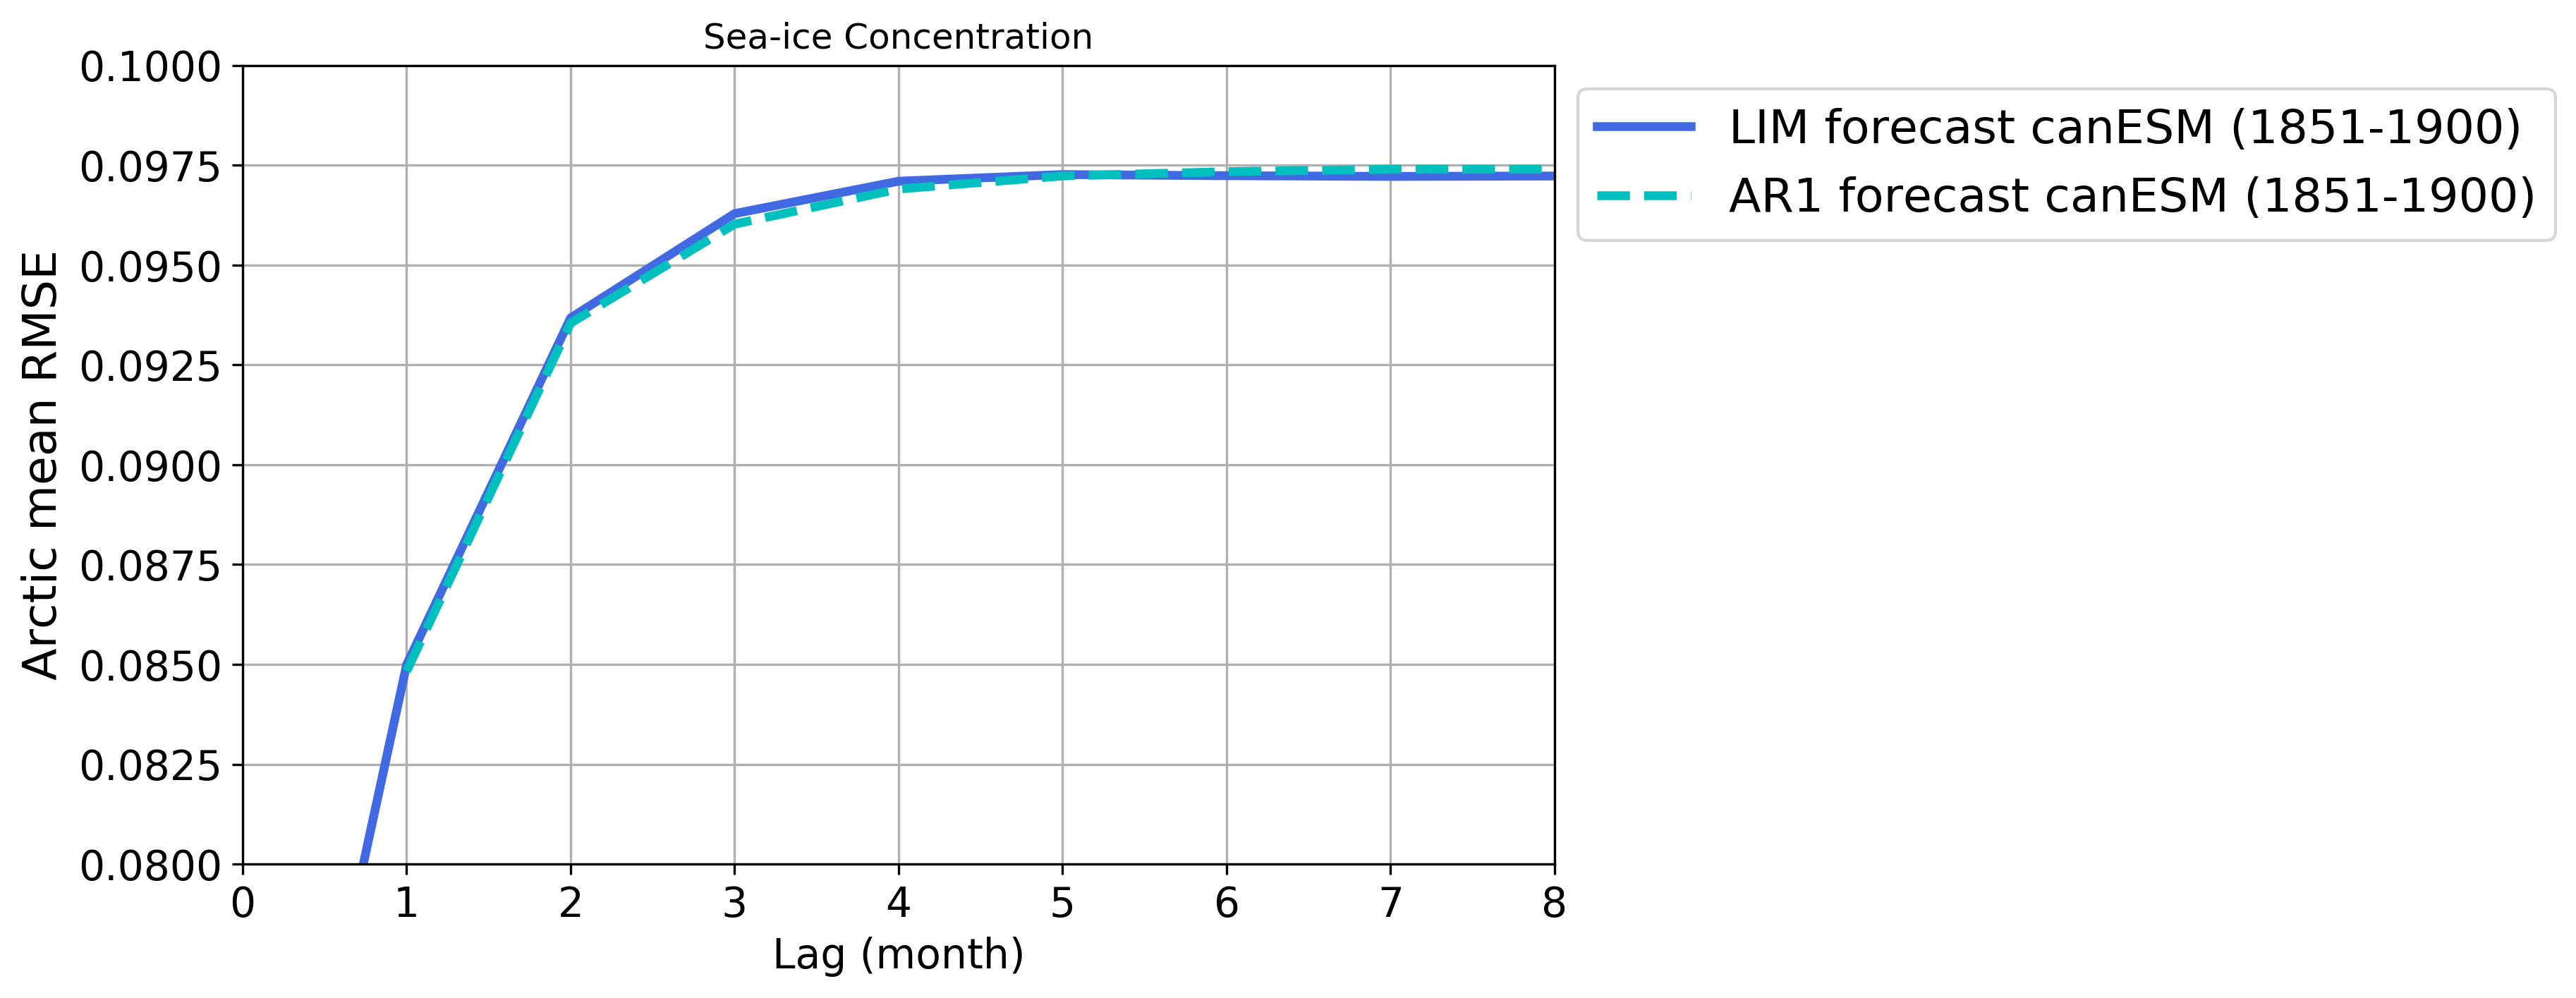

In [37]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_canESM['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast canESM (1851-1900)', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_canESM['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast canESM (1851-1900)', color='c', linewidth=3, linestyle='--')

plt.ylim(0.08,0.1)
plt.xlim(0,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Arctic mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

In [38]:
LIMd_canESM['P_train'].shape, forecast_canESM['P_train_valid'].shape

((300, 7920), (300, 1956))

Text(0.5, 1.0, 'Sea-ice Concentration')

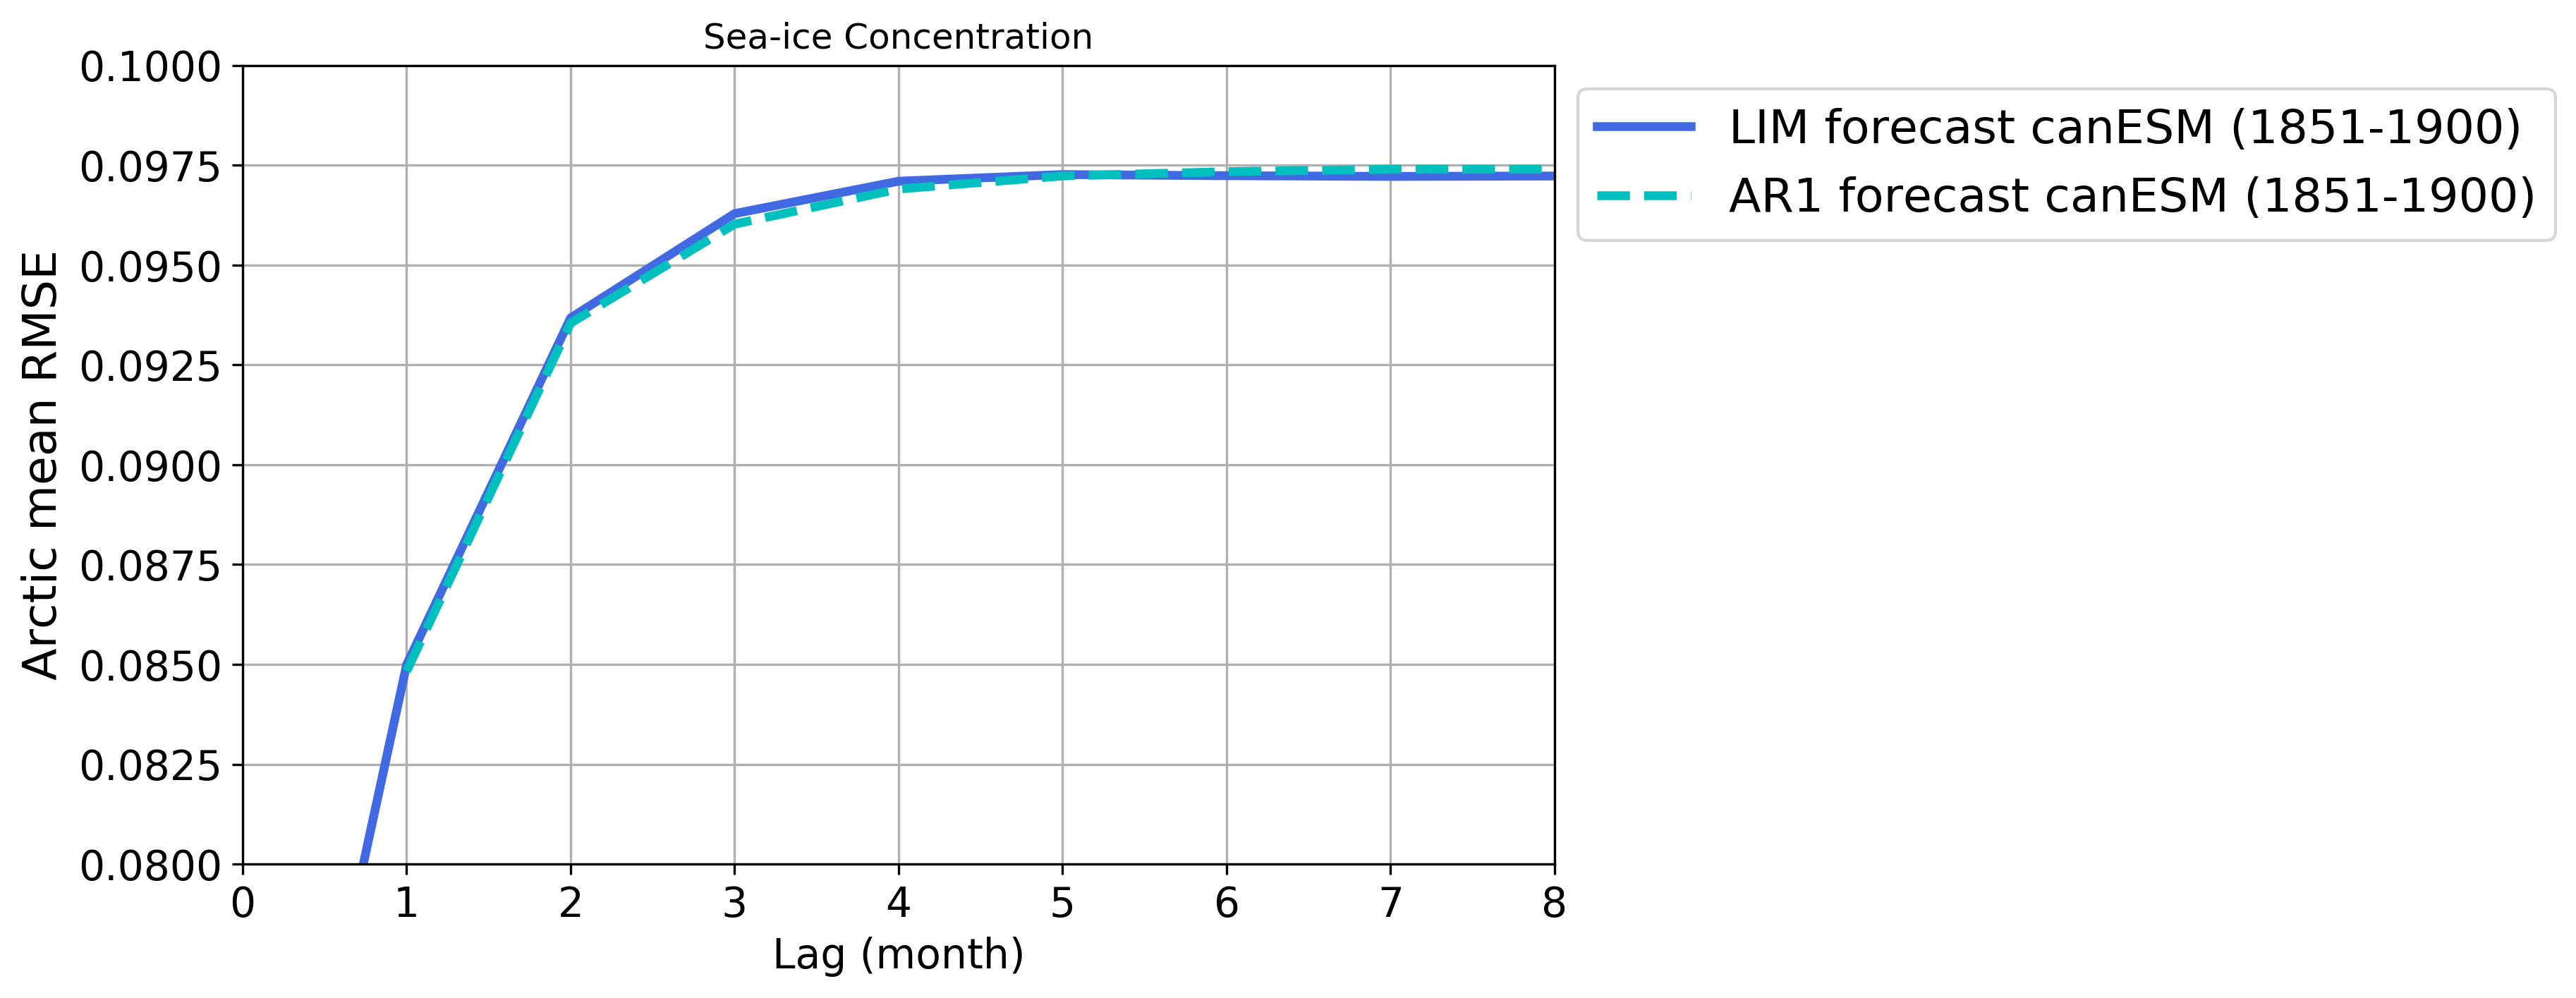

In [39]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_canESM2['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast canESM (1851-1900)', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_canESM2['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast canESM (1851-1900)', color='c', linewidth=3, linestyle='--')

plt.ylim(0.08,0.1)
plt.xlim(0,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Arctic mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

Text(0.5, 1.0, 'Sea-ice Concentration')

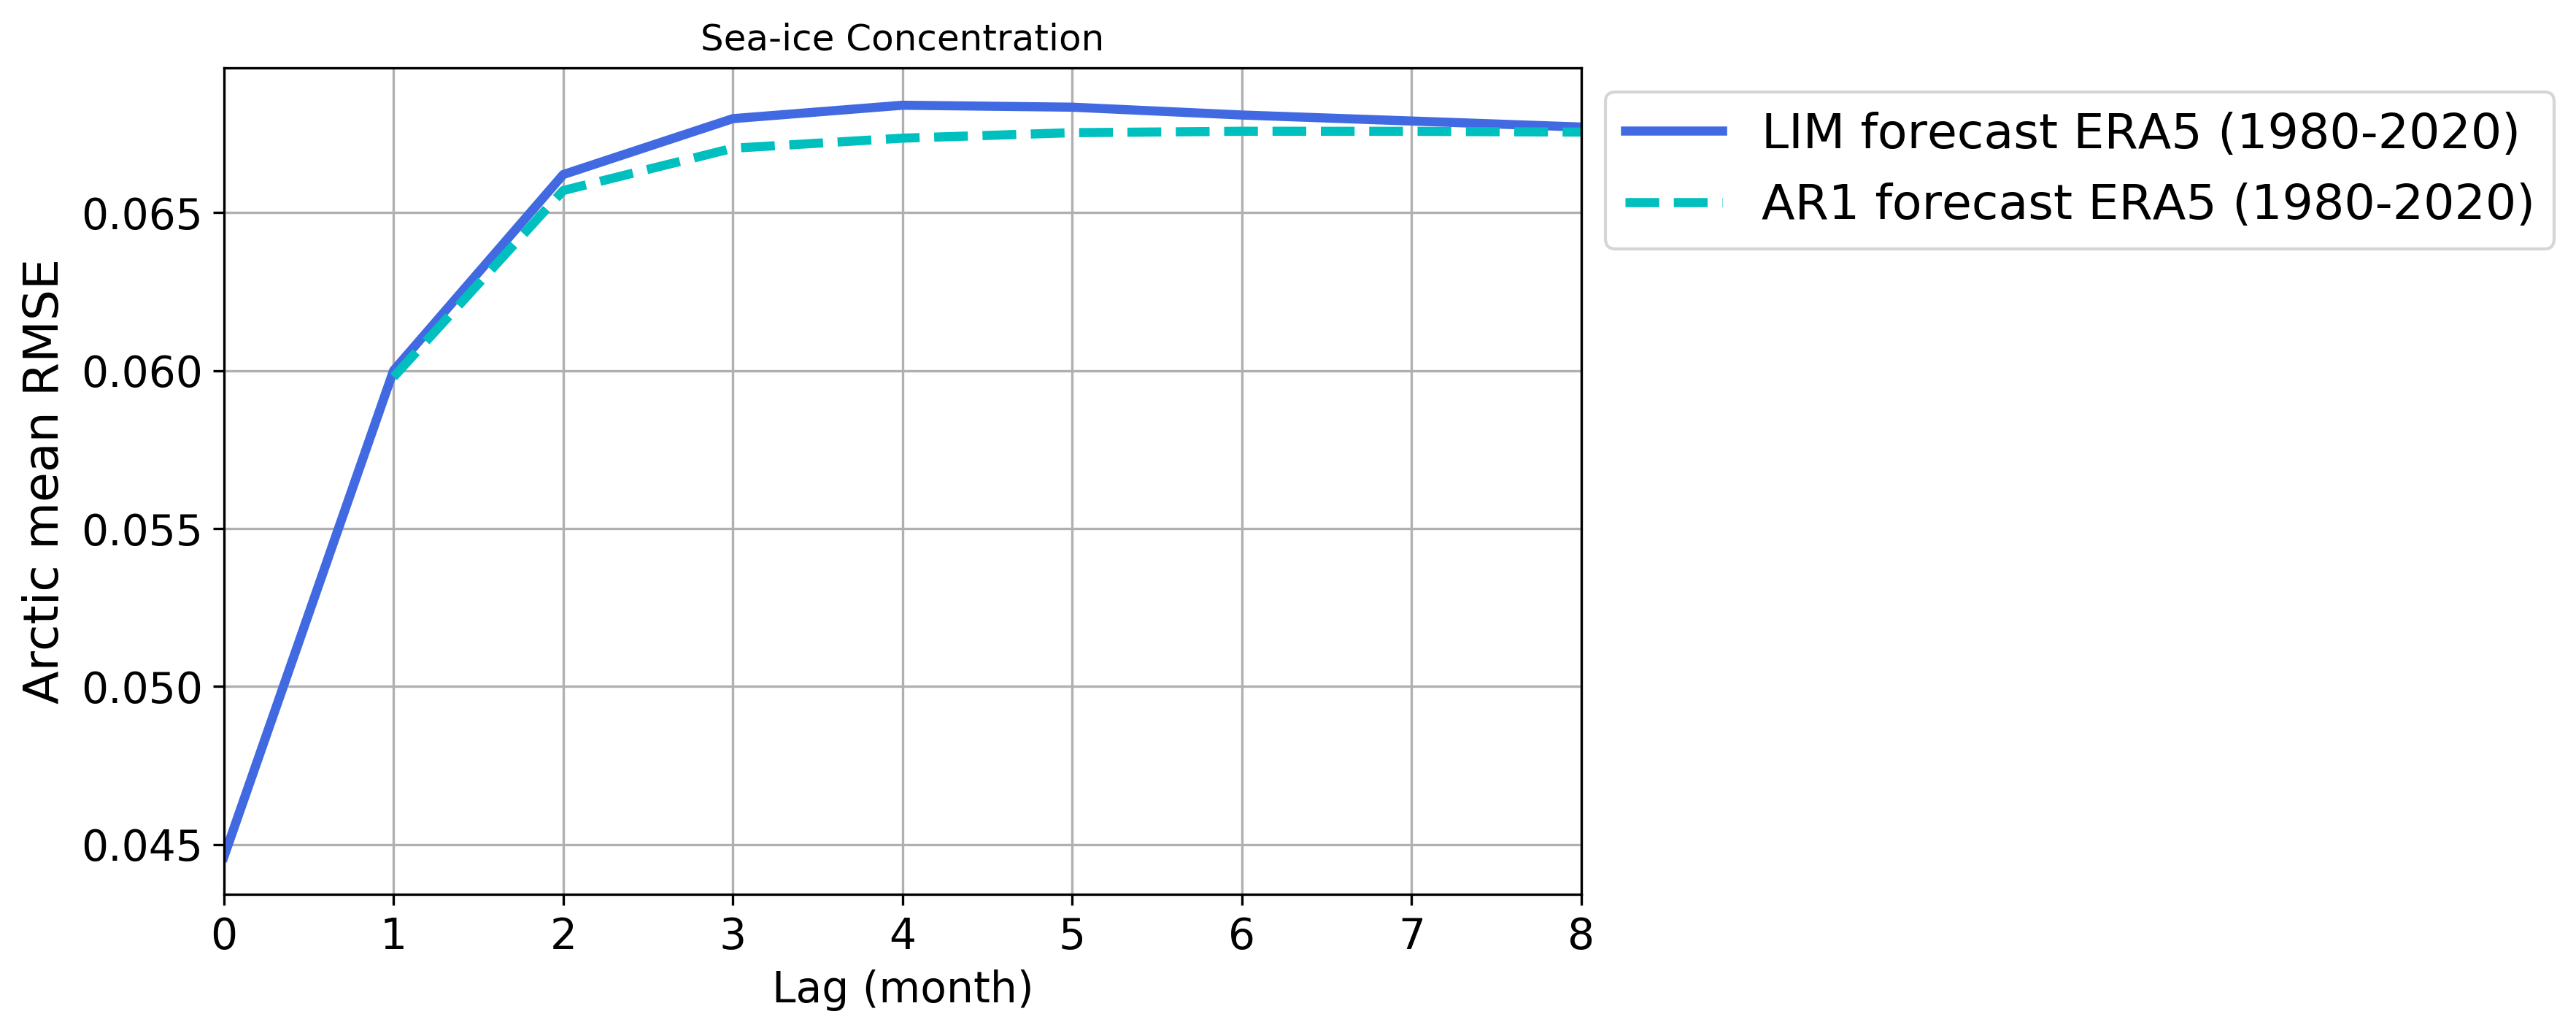

In [48]:
var = 'sic'
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_era5['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast ERA5 (1980-2020)', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_era5['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast ERA5 (1980-2020)', color='c', linewidth=3, linestyle='--')

# plt.ylim(0.08,0.1)
plt.xlim(0,8)
#plt.ylim(1.75,1.95)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Arctic mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)
plt.title('Sea-ice Concentration')

In [3]:
%run run_forecast_LME_nvalid_sensitivity_120221.py

Loading truncated tas from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/tas_ntrunc50_002_monthall_cesm_lme_Amon_latcutoff_0.1_wtTrue_dtTrue_ntrain_850_1650_20211014_sqrtWt.pkl
Month is all
Loading truncated psl from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/psl_ntrunc50_002_monthall_cesm_lme_Amon_latcutoff_0.1_wtTrue_dtTrue_ntrain_850_1650_20211014_sqrtWt.pkl
Month is all
Loading truncated zg from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/zg_ntrunc50_002_monthall_cesm_lme_Amon_latcutoff_0.1_wtTrue_dtTrue_ntrain_850_1650_20211014_sqrtWt.pkl
Month is all
Loading truncated tos from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/tos_ntrunc50_002_monthall_cesm_lme_Amon_latcutoff_0.1_wtTrue_dtTrue_ntrain_850_1650_20211014_sqrtWt.pkl
Month is all
Loading truncated sit from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/sit_ntrunc50_002_monthall_cesm_lme_Amon_latcutoff_40_wtTrue_dtTrue_ntrain_

lag= 2
lag= 3
lag= 4
lag= 5
lag= 6
lag= 7
lag= 8
LIM_fcast: (9, 300, 2400)
Decompressing forecasted fields out of eof space.
Working on...
Lag 0
Lag 1
Lag 2
Lag 3
Lag 4
Lag 5
Lag 6
Lag 7
Lag 8
------------------------------------------------
------------------------------------------------
STARTING validate_forecast_monthly()
------------------------------------------------
------------------------------------------------
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM

Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
tecut = 1001, tscut = 801.0
Loading from tos
Loading from os_sfc_Omon_CESM_LMEallforc_002_regrid_Amon_085001-200512.nc
time dimension: 1651 - 1850
latitude cutoff detected: 0.1
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in sa

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (3888, 200)
Forecast_anom shape: (3888, 200)
changing cellarea units from m^2 to km^2
----------

Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in satellite), going to fill with zeros...
Working on month...11
Found with nans (not in satellite), going to fill with zeros...
-----------------------------------------------------
completed in 5.3868632316589355 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (6912, 2400)
Forecast_anom shape: (6912, 2400)
changing cellarea units from m^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (6912, 2399)
Forecast_anom shape: (6912, 2399)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (6912, 2398)
Forecast_anom shape: (6912, 2398)
changing cellarea units from m^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (6912, 2397)
Forecast_anom shape: (691

Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 6.406858921051025 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (6912, 199)
Forecast_anom shape: (6912, 199)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
Month 4
Trained using month 4...
Validating agai

Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in satellite), going to fill with zeros...
Working on month...11
Found with nans (not in satellite), going to fill with zeros...
-----------------------------------------------------
completed in 6.1048548221588135 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (6912, 199)
Forecast_anom shape: (6912, 199)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
Month 3
Trained us

------------------------------------------------
------------------------------------------------
STARTING ar1_forecast_valid_by_lag()
------------------------------------------------
------------------------------------------------
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Lead = 1
Lead = 2
Lead = 3
Lead = 4
Lead = 5
Lead = 6
Lead = 7
Lead = 8
tecut = 1001, tscut = 801.0
Loading from tas
Loading from a/LME/LIMs/tas_

Lag 7
Trained using all months...
Truth_anom shape: (6912, 2393)
Forecast_anom shape: (6912, 2393)
changing cellarea units from m^2 to km^2
Lag 8
Trained using all months...
Truth_anom shape: (6912, 2392)
Forecast_anom shape: (6912, 2392)
changing cellarea units from m^2 to km^2
tecut = 1001, tscut = 801.0
Loading from sit
Loading from /LIMs/sit_SImon_CESM_LME_nh_002_regrid_Amon_085001-200512.nc
time dimension: 1651 - 1850
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6